<a href="https://colab.research.google.com/github/thangthao22/python-training/blob/main/M%C3%B4_ph%E1%BB%8Fng_cho_b%C3%A0i_b%C3%A1o_s%E1%BB%91_4_rins_memetic_for_TS_fog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task scheduling in Fog computing Memetic algorithm

[Memetic]  Total Latency: 142.29 s | Energy: 14228.91 J
[GA]       Total Latency: 136.51 s | Energy: 13650.93 J
[RR]       Total Latency: 177.37 s | Energy: 17737.43 J


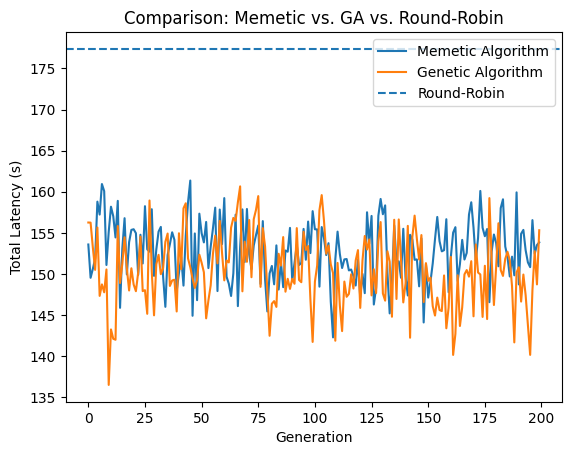

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy

# Thiết lập tham số mô phỏng
NUM_FOG_NODES = 10  # Số nút fog
NUM_TASKS = 50      # Số tác vụ
POP_SIZE = 100      # Kích thước quần thể
CROSSOVER_RATE = 0.8  # Tỷ lệ lai ghép
MUTATION_RATE = 0.2   # Tỷ lệ đột biến
MAX_GENERATIONS = 200  # Số thế hệ tối đa
CPU_THRESHOLD = 0.8   # Ngưỡng quá tải CPU (80%)
DELTA = 1.0           # Ngưỡng độ trễ (giây)

# Lớp định nghĩa Fog Node
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth, energy):
        self.id = id
        self.cpu_capacity = cpu_capacity  # MIPS
        self.bandwidth = bandwidth        # Mbps
        self.energy = energy              # Joules
        self.current_cpu_load = 0         # MIPS đã sử dụng
        self.current_tasks = []           # Danh sách tác vụ được gán

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

# Lớp định nghĩa Task
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size         # MB
        self.processing_time = processing_time  # giây
        self.priority = priority           # 0-1
        self.computation_size = data_size * 10   # Giả lập: 1 MB = 10 MIPS

# Hàm khởi tạo hệ thống
def initialize_system():
    fog_nodes = []
    for i in range(NUM_FOG_NODES):
        cpu_capacity = random.uniform(1000, 5000)  # 1000-5000 MIPS
        bandwidth = random.uniform(10, 50)         # 10-50 Mbps
        energy = random.uniform(1000, 5000)        # 1000-5000 J
        fog_nodes.append(FogNode(i, cpu_capacity, bandwidth, energy))

    tasks = []
    for i in range(NUM_TASKS):
        data_size = random.uniform(10, 100)        # 10-100 MB
        processing_time = random.uniform(1, 5)     # 1-5 giây
        priority = random.uniform(0.3, 0.9)        # 0.3-0.9
        tasks.append(Task(i, data_size, processing_time, priority))

    return fog_nodes, tasks

# Hàm tính độ trễ hoàn thành trên một nút fog
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    if node.cpu_capacity == 0:
        return float('inf')
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# Hàm tính năng lượng tiêu thụ (giản lược)
def compute_energy(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_time = compute_completion_time(node, tasks_assigned)
    energy_per_second = 100  # Giả lập: 100 J/giây
    return total_time * energy_per_second

# Hàm tính fitness (tổng độ trễ của toàn hệ thống)
def evaluate_individual(individual, fog_nodes, tasks):
    # Reset
    for node in fog_nodes:
        node.reset_load()

    # Gán task
    for task_id, node_id in enumerate(individual):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size

    # Tính tổng độ trễ
    total_latency = sum(compute_completion_time(node, node.current_tasks)
                        for node in fog_nodes)
    return total_latency

# Hàm khởi tạo quần thể
def initialize_population(pop_size, num_tasks, num_fog_nodes):
    population = []
    for _ in range(pop_size):
        individual = [random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)]
        population.append(individual)
    return population

# Hàm lai ghép (crossover)
def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

# Hàm đột biến (mutation)
def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

# Hàm tìm kiếm cục bộ (hill climbing) - dùng trong Memetic
def local_search(individual, fog_nodes, tasks):
    best_individual = individual[:]
    best_fitness = evaluate_individual(best_individual, fog_nodes, tasks)
    for _ in range(5):  # Số lần tìm kiếm cục bộ
        neighbor = best_individual[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        neighbor_fitness = evaluate_individual(neighbor, fog_nodes, tasks)
        if neighbor_fitness < best_fitness:
            best_individual = neighbor[:]
            best_fitness = neighbor_fitness
    return best_individual

# Hàm tái phân bổ để cân bằng tải (sử dụng trong Memetic)
def reassign_tasks(individual, fog_nodes, tasks):
    # Tính độ trễ trung bình
    for node in fog_nodes:
        node.reset_load()
        node.current_tasks = [tasks[i] for i, node_id in enumerate(individual) if node_id == node.id]
        node.current_cpu_load = sum(task.computation_size for task in node.current_tasks)

    latencies = [compute_completion_time(node, node.current_tasks) for node in fog_nodes]
    non_zero_lat = [lat for lat in latencies if lat > 0]
    if not non_zero_lat:
        return individual

    avg_latency = np.mean(non_zero_lat)

    # Xác định nút quá tải và tái phân bổ
    for node in fog_nodes:
        latency = compute_completion_time(node, node.current_tasks)
        if node.cpu_capacity == 0:
            cpu_usage = 1.0
        else:
            cpu_usage = node.current_cpu_load / node.cpu_capacity

        if cpu_usage > CPU_THRESHOLD or (latency > avg_latency + DELTA and latency > 0):
            # Tìm nút có tài nguyên dư thừa
            underloaded_nodes = [
                n for n in fog_nodes
                if (n.cpu_capacity > 0 and (n.current_cpu_load / n.cpu_capacity) < 0.5)
                  and n.bandwidth > 10
                  and n.energy > 0.5 * 5000
            ]
            if underloaded_nodes and node.current_tasks:
                # Chuyển một tác vụ từ nút quá tải sang nút dư thừa
                task_to_move = node.current_tasks[-1]  # Lấy task cuối làm ví dụ
                task_idx = tasks.index(task_to_move)
                target_node = min(underloaded_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
                individual[task_idx] = target_node.id
    return individual

# -----------------------
# THUẬT TOÁN MEMETIC
# -----------------------
def memetic_algorithm(fog_nodes, tasks):
    num_tasks = len(tasks)
    num_fog_nodes = len(fog_nodes)

    population = initialize_population(POP_SIZE, num_tasks, num_fog_nodes)
    best_individual = None
    best_fitness = float('inf')
    fitness_history = []

    for gen in range(MAX_GENERATIONS):
        # Đánh giá quần thể
        fitness_values = [evaluate_individual(ind, fog_nodes, tasks) for ind in population]
        min_fitness = min(fitness_values)

        if min_fitness < best_fitness:
            best_fitness = min_fitness
            best_individual = population[fitness_values.index(min_fitness)][:]
        fitness_history.append(min_fitness)

        # Tạo quần thể mới
        new_population = []
        for _ in range(POP_SIZE // 2):
            # Chọn lọc
            # Lưu ý: để tránh chia cho 0, ta có thể lọc ra f=0 => weight=∞,
            # nhưng trong ví dụ này ta chấp nhận f=0 => weight=∞
            parents = random.choices(population, weights=[1/f if f > 0 else float('inf')
                                                          for f in fitness_values],
                                     k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            # Lai ghép
            child1, child2 = crossover(parent1, parent2, CROSSOVER_RATE)
            # Đột biến
            child1 = mutate(child1, num_fog_nodes, MUTATION_RATE)
            child2 = mutate(child2, num_fog_nodes, MUTATION_RATE)
            # Tìm kiếm cục bộ
            child1 = local_search(child1, fog_nodes, tasks)
            child2 = local_search(child2, fog_nodes, tasks)
            new_population.extend([child1, child2])

        # Cân bằng tải
        new_population = [reassign_tasks(ind, fog_nodes, tasks) for ind in new_population]
        population = new_population

    return best_individual, best_fitness, fitness_history

# -----------------------
# THUẬT TOÁN GA (MỚI)
# -----------------------
def genetic_algorithm(fog_nodes, tasks):
    """
    GA thuần tuý (không local search, không reassign).
    So sánh với Memetic Algorithm & Round Robin.
    """
    num_tasks = len(tasks)
    num_fog_nodes = len(fog_nodes)

    population = initialize_population(POP_SIZE, num_tasks, num_fog_nodes)
    fitness_history = []
    best_individual = None
    best_fitness = float('inf')

    for _ in range(MAX_GENERATIONS):
        fitness_values = [evaluate_individual(ind, fog_nodes, tasks) for ind in population]
        min_fitness = min(fitness_values)
        if min_fitness < best_fitness:
            best_fitness = min_fitness
            best_individual = population[fitness_values.index(min_fitness)][:]
        fitness_history.append(min_fitness)

        # Tạo thế hệ mới
        new_population = []
        for _ in range(POP_SIZE // 2):
            # Chọn lọc
            parents = random.choices(population, weights=[1/f if f > 0 else float('inf')
                                                          for f in fitness_values],
                                     k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            # Lai ghép
            child1, child2 = crossover(parent1, parent2, CROSSOVER_RATE)
            # Đột biến
            child1 = mutate(child1, num_fog_nodes, MUTATION_RATE)
            child2 = mutate(child2, num_fog_nodes, MUTATION_RATE)
            new_population.extend([child1, child2])

        # Cập nhật quần thể
        population = new_population

    return best_individual, best_fitness, fitness_history

# Hàm lập lịch Round-Robin (để so sánh)
def round_robin(fog_nodes, tasks):
    individual = [0] * len(tasks)
    for i in range(len(tasks)):
        individual[i] = i % len(fog_nodes)
    return individual

# -----------------------
# HÀM CHÍNH CHẠY MÔ PHỎNG
# -----------------------
def run_simulation():
    fog_nodes, tasks = initialize_system()

    # 1) Chạy Memetic Algorithm
    ma_individual, ma_fitness, ma_history = memetic_algorithm(fog_nodes, tasks)
    # Tính năng lượng
    ma_energy = sum(
        compute_energy(node, [tasks[i] for i, node_id in enumerate(ma_individual) if node_id == node.id])
        for node in fog_nodes
    )

    # 2) Chạy GA
    ga_individual, ga_fitness, ga_history = genetic_algorithm(fog_nodes, tasks)
    ga_energy = sum(
        compute_energy(node, [tasks[i] for i, node_id in enumerate(ga_individual) if node_id == node.id])
        for node in fog_nodes
    )

    # 3) Chạy Round-Robin
    rr_individual = round_robin(fog_nodes, tasks)
    rr_fitness = evaluate_individual(rr_individual, fog_nodes, tasks)
    rr_energy = sum(
        compute_energy(node, [tasks[i] for i, node_id in enumerate(rr_individual) if node_id == node.id])
        for node in fog_nodes
    )

    # In kết quả
    print(f"[Memetic]  Total Latency: {ma_fitness:.2f} s | Energy: {ma_energy:.2f} J")
    print(f"[GA]       Total Latency: {ga_fitness:.2f} s | Energy: {ga_energy:.2f} J")
    print(f"[RR]       Total Latency: {rr_fitness:.2f} s | Energy: {rr_energy:.2f} J")

    # Vẽ biểu đồ hội tụ
    plt.plot(ma_history, label="Memetic Algorithm")
    plt.plot(ga_history, label="Genetic Algorithm")
    # Vẽ đường ngang Round-Robin (so sánh)
    plt.axhline(y=rr_fitness, linestyle='--', label="Round-Robin")

    plt.xlabel("Generation")
    plt.ylabel("Total Latency (s)")
    plt.title("Comparison: Memetic vs. GA vs. Round-Robin")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()


Thuật toán MA so sánh với GA trong bài toán lập lịch tác vụ

Đang chạy mô phỏng 1/10
Đang chạy mô phỏng 2/10
Đang chạy mô phỏng 3/10
Đang chạy mô phỏng 4/10
Đang chạy mô phỏng 5/10
Đang chạy mô phỏng 6/10
Đang chạy mô phỏng 7/10
Đang chạy mô phỏng 8/10
Đang chạy mô phỏng 9/10
Đang chạy mô phỏng 10/10

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 108.87 giây
Genetic Algorithm: 105.43 giây


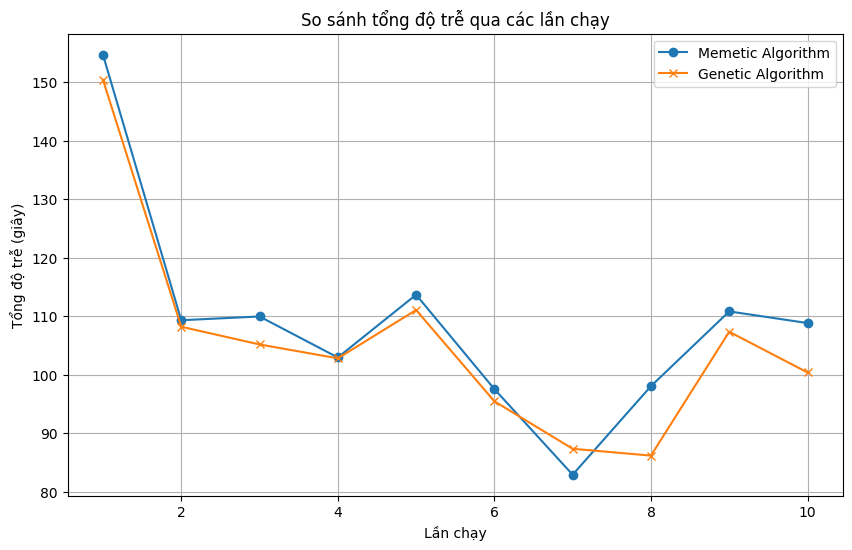

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Thiết lập tham số mô phỏng
NUM_FOG_NODES = 10  # Số nút fog
NUM_TASKS = 50      # Số tác vụ
POP_SIZE = 50       # Kích thước quần thể
CROSSOVER_RATE = 0.8  # Tỷ lệ lai ghép
MUTATION_RATE = 0.2   # Tỷ lệ đột biến
MAX_GENERATIONS = 100  # Số thế hệ tối đa
CPU_THRESHOLD = 0.8   # Ngưỡng quá tải CPU
NUM_RUNS = 10         # Số lần chạy độc lập

# Lớp FogNode
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

# Lớp Task
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10

# Khởi tạo hệ thống
def initialize_system():
    fog_nodes = [FogNode(i, random.uniform(1000, 5000), random.uniform(10, 50))
                 for i in range(NUM_FOG_NODES)]
    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9))
             for i in range(NUM_TASKS)]
    return fog_nodes, tasks

# Tính độ trễ hoàn thành
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# Tính fitness (tổng độ trễ)
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

# Khởi tạo quần thể
def initialize_population(popsize, num_tasks, num_fog_nodes):
    return [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]

# Lai ghép
def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# Đột biến
def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

# Chọn lọc
def select(population, fitnesses):
    weights = [1 / (f + 1e-6) for f in fitnesses]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    return random.choices(population, weights=weights, k=1)[0]

# Thuật toán Genetic Algorithm
def genetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitnesses = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            new_population.extend([child1, child2])
        population = new_population
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Tìm kiếm cục bộ (Memetic)
def local_search(individual, fog_nodes, tasks):
    best_individual = individual[:]
    best_fitness = fitness_function(best_individual, fog_nodes, tasks)
    for _ in range(3):
        neighbor = best_individual[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        neighbor_fitness = fitness_function(neighbor, fog_nodes, tasks)
        if neighbor_fitness < best_fitness:
            best_individual = neighbor[:]
            best_fitness = neighbor_fitness
    return best_individual

# Tái phân bổ tác vụ
def reassign_tasks(individual, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
        node.current_tasks = [tasks[i] for i, node_id in enumerate(individual) if node_id == node.id]
        node.current_cpu_load = sum(task.computation_size for task in node.current_tasks)
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        if cpu_usage > CPU_THRESHOLD and node.current_tasks:
            underloaded_nodes = [n for n in fog_nodes if (n.current_cpu_load / n.cpu_capacity) < 0.5]
            if underloaded_nodes:
                task_to_move = node.current_tasks[-1]
                task_idx = tasks.index(task_to_move)
                target_node = min(underloaded_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
                individual[task_idx] = target_node.id
    return individual

# Thuật toán Memetic Algorithm
def memetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitness_values = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            child1 = local_search(child1, fog_nodes, tasks)
            child2 = local_search(child2, fog_nodes, tasks)
            new_population.extend([child1, child2])
        population = [reassign_tasks(ind, fog_nodes, tasks) for ind in new_population]
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Chạy mô phỏng qua 10 lần lặp
def run_simulation():
    ma_latencies = []
    ga_latencies = []
    for run in range(NUM_RUNS):
        print(f"Đang chạy mô phỏng {run + 1}/{NUM_RUNS}")
        fog_nodes, tasks = initialize_system()

        # Chạy Memetic Algorithm
        ma_fitness = memetic_algorithm(
            POP_SIZE, MAX_GENERATIONS, NUM_FOG_NODES, NUM_TASKS, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
        )
        ma_latencies.append(ma_fitness)

        # Chạy Genetic Algorithm
        ga_fitness = genetic_algorithm(
            POP_SIZE, MAX_GENERATIONS, NUM_FOG_NODES, NUM_TASKS, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
        )
        ga_latencies.append(ga_fitness)

    # In kết quả trung bình
    print(f"\nĐộ trễ hoàn thành trung bình qua {NUM_RUNS} lần chạy:")
    print(f"Memetic Algorithm: {np.mean(ma_latencies):.2f} giây")
    print(f"Genetic Algorithm: {np.mean(ga_latencies):.2f} giây")

    # Vẽ biểu đồ so sánh
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, NUM_RUNS + 1), ma_latencies, label="Memetic Algorithm", marker='o')
    plt.plot(range(1, NUM_RUNS + 1), ga_latencies, label="Genetic Algorithm", marker='x')
    plt.xlabel("Lần chạy")
    plt.ylabel("Tổng độ trễ (giây)")
    plt.title("So sánh tổng độ trễ qua các lần chạy")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()

Thuật toán MA, GA, SA trong bại toán lập lịch nhiệm vụ cho fog computing


=== Kịch bản: Cơ bản ===
Đang chạy mô phỏng 1/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 2/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 3/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 4/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 5/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 6/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 7/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 8/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 9/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 10/10 cho kịch bản Cơ bản

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 121.20 giây
Genetic Algorithm: 118.68 giây
Simulated Annealing: 109.12 giây


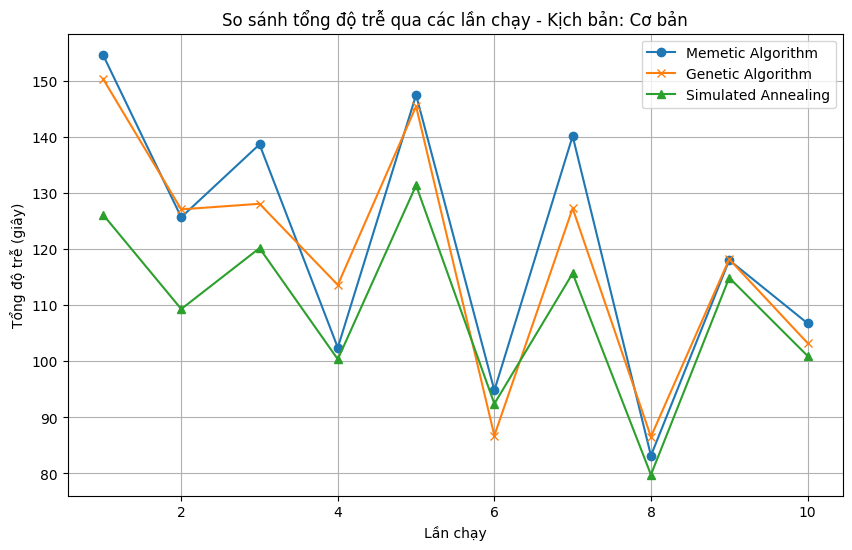


=== Kịch bản: Tăng số tác vụ ===
Đang chạy mô phỏng 1/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 2/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 3/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 4/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 5/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 6/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 7/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 8/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 9/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 10/10 cho kịch bản Tăng số tác vụ

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 208.40 giây
Genetic Algorithm: 212.19 giây
Simulated Annealing: 202.29 giây


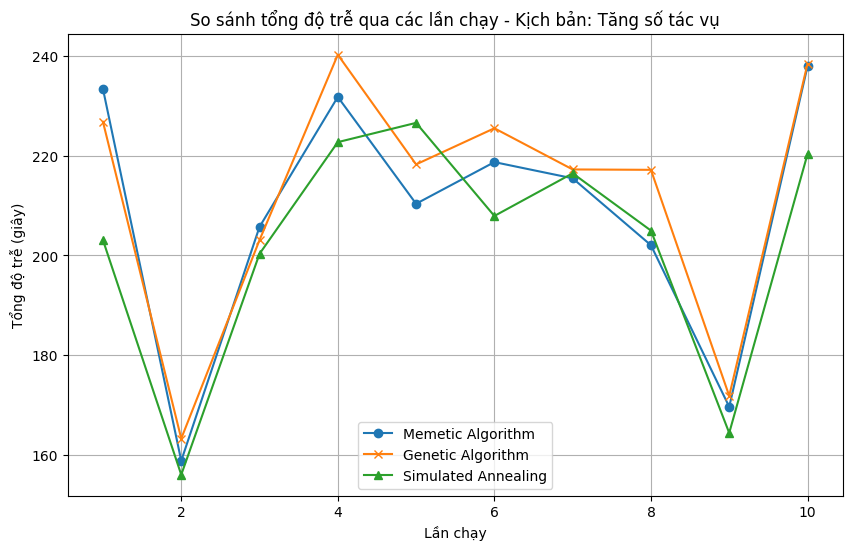


=== Kịch bản: Tăng số nút fog ===
Đang chạy mô phỏng 1/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 2/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 3/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 4/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 5/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 6/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 7/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 8/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 9/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 10/10 cho kịch bản Tăng số nút fog

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 105.92 giây
Genetic Algorithm: 105.78 giây
Simulated Annealing: 99.23 giây


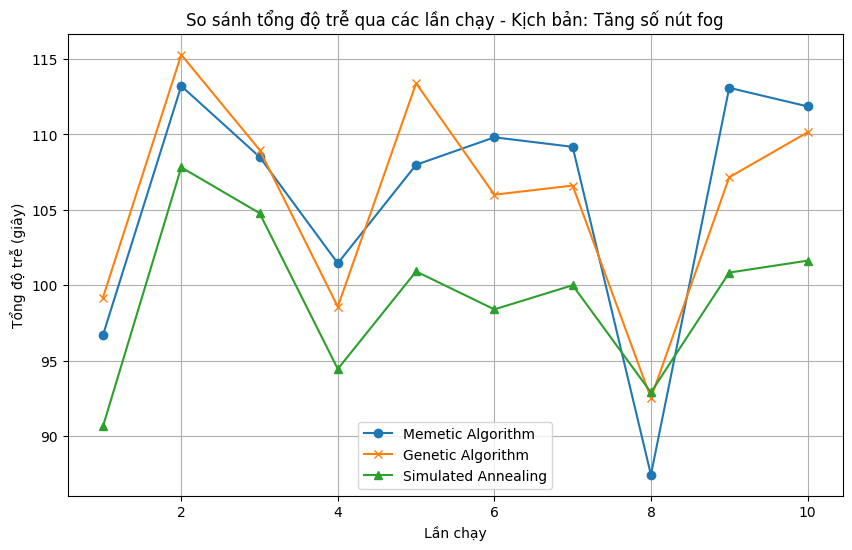

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

# Thiết lập tham số mô phỏng
POP_SIZE = 50       # Kích thước quần thể
CROSSOVER_RATE = 0.8  # Tỷ lệ lai ghép
MUTATION_RATE = 0.2   # Tỷ lệ đột biến
MAX_GENERATIONS = 100  # Số thế hệ tối đa
CPU_THRESHOLD = 0.8   # Ngưỡng quá tải CPU
NUM_RUNS = 10         # Số lần chạy độc lập

# Các kịch bản mô phỏng
SCENARIOS = [
    {"name": "Cơ bản", "NUM_FOG_NODES": 10, "NUM_TASKS": 50},
    {"name": "Tăng số tác vụ", "NUM_FOG_NODES": 10, "NUM_TASKS": 100},
    {"name": "Tăng số nút fog", "NUM_FOG_NODES": 20, "NUM_TASKS": 50},
]

# Lớp FogNode
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

# Lớp Task
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10

# Khởi tạo hệ thống
def initialize_system(num_fog_nodes, num_tasks):
    fog_nodes = [FogNode(i, random.uniform(1000, 5000), random.uniform(10, 50))
                 for i in range(num_fog_nodes)]
    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9))
             for i in range(num_tasks)]
    return fog_nodes, tasks

# Tính độ trễ hoàn thành
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# Tính fitness (tổng độ trễ)
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

# Khởi tạo quần thể
def initialize_population(popsize, num_tasks, num_fog_nodes):
    return [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]

# Lai ghép
def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# Đột biến
def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

# Chọn lọc
def select(population, fitnesses):
    weights = [1 / (f + 1e-6) for f in fitnesses]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    return random.choices(population, weights=weights, k=1)[0]

# Thuật toán Genetic Algorithm (GA)
def genetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitnesses = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            new_population.extend([child1, child2])
        population = new_population
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Tìm kiếm cục bộ (Memetic)
def local_search(individual, fog_nodes, tasks):
    best_individual = individual[:]
    best_fitness = fitness_function(best_individual, fog_nodes, tasks)
    for _ in range(3):
        neighbor = best_individual[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        neighbor_fitness = fitness_function(neighbor, fog_nodes, tasks)
        if neighbor_fitness < best_fitness:
            best_individual = neighbor[:]
            best_fitness = neighbor_fitness
    return best_individual

# Tái phân bổ tác vụ
def reassign_tasks(individual, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
        node.current_tasks = [tasks[i] for i, node_id in enumerate(individual) if node_id == node.id]
        node.current_cpu_load = sum(task.computation_size for task in node.current_tasks)
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        if cpu_usage > CPU_THRESHOLD and node.current_tasks:
            underloaded_nodes = [n for n in fog_nodes if (n.current_cpu_load / n.cpu_capacity) < 0.5]
            if underloaded_nodes:
                task_to_move = node.current_tasks[-1]
                task_idx = tasks.index(task_to_move)
                target_node = min(underloaded_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
                individual[task_idx] = target_node.id
    return individual

# Thuật toán Memetic Algorithm (MA)
def memetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitness_values = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            child1 = local_search(child1, fog_nodes, tasks)
            child2 = local_search(child2, fog_nodes, tasks)
            new_population.extend([child1, child2])
        population = [reassign_tasks(ind, fog_nodes, tasks) for ind in new_population]
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Thuật toán Simulated Annealing (SA)
def simulated_annealing(num_fog_nodes, num_tasks, fog_nodes, tasks, initial_temp=1000, cooling_rate=0.99, min_temp=1, max_iterations=1000):
    # Khởi tạo giải pháp ban đầu
    current_solution = [random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)]
    current_fitness = fitness_function(current_solution, fog_nodes, tasks)
    best_solution = current_solution[:]
    best_fitness = current_fitness

    temp = initial_temp
    for _ in range(max_iterations):
        if temp < min_temp:
            break

        # Tạo giải pháp hàng xóm
        neighbor = current_solution[:]
        idx = random.randint(0, num_tasks - 1)
        neighbor[idx] = random.randint(0, num_fog_nodes - 1)
        neighbor_fitness = fitness_function(neighbor, fog_nodes, tasks)

        # Tính delta
        delta = neighbor_fitness - current_fitness

        # Chấp nhận giải pháp mới
        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_solution = neighbor[:]
            current_fitness = neighbor_fitness

        # Cập nhật giải pháp tốt nhất
        if current_fitness < best_fitness:
            best_solution = current_solution[:]
            best_fitness = current_fitness

        # Giảm nhiệt độ
        temp *= cooling_rate

    return best_fitness

# Chạy mô phỏng cho từng kịch bản
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Kịch bản: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]

        ma_latencies = []
        ga_latencies = []
        sa_latencies = []

        for run in range(NUM_RUNS):
            print(f"Đang chạy mô phỏng {run + 1}/{NUM_RUNS} cho kịch bản {scenario['name']}")
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks)

            # Chạy Memetic Algorithm
            ma_fitness = memetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ma_latencies.append(ma_fitness)

            # Chạy Genetic Algorithm
            ga_fitness = genetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ga_latencies.append(ga_fitness)

            # Chạy Simulated Annealing
            sa_fitness = simulated_annealing(
                num_fog_nodes, num_tasks, fog_nodes, tasks
            )
            sa_latencies.append(sa_fitness)

        # In kết quả trung bình
        print(f"\nĐộ trễ hoàn thành trung bình qua {NUM_RUNS} lần chạy:")
        print(f"Memetic Algorithm: {np.mean(ma_latencies):.2f} giây")
        print(f"Genetic Algorithm: {np.mean(ga_latencies):.2f} giây")
        print(f"Simulated Annealing: {np.mean(sa_latencies):.2f} giây")

        # Vẽ biểu đồ so sánh
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, NUM_RUNS + 1), ma_latencies, label="Memetic Algorithm", marker='o')
        plt.plot(range(1, NUM_RUNS + 1), ga_latencies, label="Genetic Algorithm", marker='x')
        plt.plot(range(1, NUM_RUNS + 1), sa_latencies, label="Simulated Annealing", marker='^')
        plt.xlabel("Lần chạy")
        plt.ylabel("Tổng độ trễ (giây)")
        plt.title(f"So sánh tổng độ trễ qua các lần chạy - Kịch bản: {scenario['name']}")
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()

Thay thế SA bằng PSO


=== Kịch bản: Cơ bản ===
Đang chạy mô phỏng 1/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 2/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 3/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 4/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 5/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 6/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 7/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 8/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 9/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 10/10 cho kịch bản Cơ bản

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 106.73 giây
Genetic Algorithm: 103.85 giây
Particle Swarm Optimization: 74.72 giây


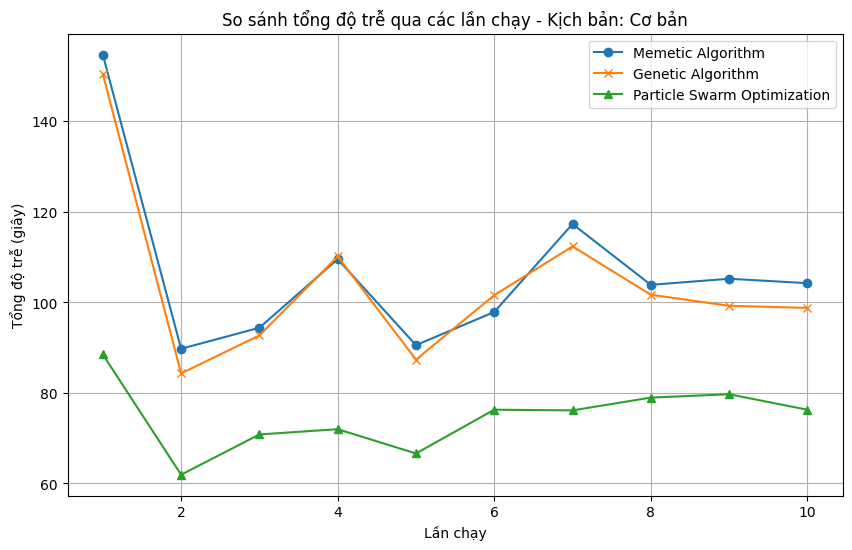


=== Kịch bản: Tăng số tác vụ ===
Đang chạy mô phỏng 1/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 2/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 3/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 4/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 5/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 6/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 7/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 8/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 9/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 10/10 cho kịch bản Tăng số tác vụ

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 226.97 giây
Genetic Algorithm: 231.70 giây
Particle Swarm Optimization: 155.55 giây


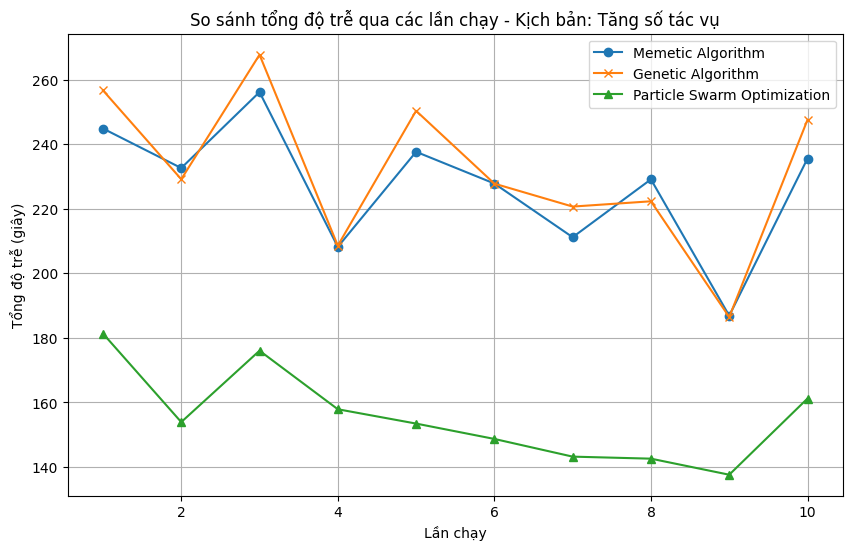


=== Kịch bản: Tăng số nút fog ===
Đang chạy mô phỏng 1/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 2/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 3/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 4/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 5/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 6/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 7/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 8/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 9/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 10/10 cho kịch bản Tăng số nút fog

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 107.10 giây
Genetic Algorithm: 106.44 giây
Particle Swarm Optimization: 70.97 giây


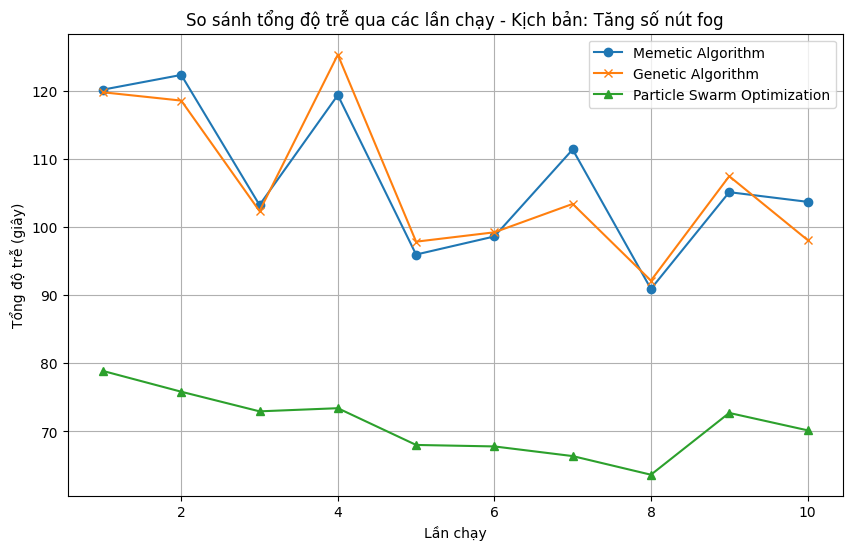

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Thiết lập tham số mô phỏng
POP_SIZE = 50       # Kích thước quần thể
CROSSOVER_RATE = 0.8  # Tỷ lệ lai ghép
MUTATION_RATE = 0.2   # Tỷ lệ đột biến
MAX_GENERATIONS = 100  # Số thế hệ tối đa
CPU_THRESHOLD = 0.8   # Ngưỡng quá tải CPU
NUM_RUNS = 10         # Số lần chạy độc lập

# Các tham số cho PSO
NUM_PARTICLES = 50    # Số hạt trong PSO
W = 0.5               # Hệ số quán tính (inertia weight)
C1 = 1.5              # Hệ số học từ pbest (cognitive)
C2 = 1.5              # Hệ số học từ gbest (social)

# Các kịch bản mô phỏng
SCENARIOS = [
    {"name": "Cơ bản", "NUM_FOG_NODES": 10, "NUM_TASKS": 50},
    {"name": "Tăng số tác vụ", "NUM_FOG_NODES": 10, "NUM_TASKS": 100},
    {"name": "Tăng số nút fog", "NUM_FOG_NODES": 20, "NUM_TASKS": 50},
]

# Lớp FogNode
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

# Lớp Task
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10

# Khởi tạo hệ thống
def initialize_system(num_fog_nodes, num_tasks):
    fog_nodes = [FogNode(i, random.uniform(1000, 5000), random.uniform(10, 50))
                 for i in range(num_fog_nodes)]
    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9))
             for i in range(num_tasks)]
    return fog_nodes, tasks

# Tính độ trễ hoàn thành
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# Tính fitness (tổng độ trễ)
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

# Khởi tạo quần thể
def initialize_population(popsize, num_tasks, num_fog_nodes):
    return [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]

# Lai ghép
def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# Đột biến
def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

# Chọn lọc
def select(population, fitnesses):
    weights = [1 / (f + 1e-6) for f in fitnesses]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    return random.choices(population, weights=weights, k=1)[0]

# Thuật toán Genetic Algorithm (GA)
def genetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitnesses = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            new_population.extend([child1, child2])
        population = new_population
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Tìm kiếm cục bộ (Memetic)
def local_search(individual, fog_nodes, tasks):
    best_individual = individual[:]
    best_fitness = fitness_function(best_individual, fog_nodes, tasks)
    for _ in range(3):
        neighbor = best_individual[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        neighbor_fitness = fitness_function(neighbor, fog_nodes, tasks)
        if neighbor_fitness < best_fitness:
            best_individual = neighbor[:]
            best_fitness = neighbor_fitness
    return best_individual

# Tái phân bổ tác vụ
def reassign_tasks(individual, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
        node.current_tasks = [tasks[i] for i, node_id in enumerate(individual) if node_id == node.id]
        node.current_cpu_load = sum(task.computation_size for task in node.current_tasks)
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        if cpu_usage > CPU_THRESHOLD and node.current_tasks:
            underloaded_nodes = [n for n in fog_nodes if (n.current_cpu_load / n.cpu_capacity) < 0.5]
            if underloaded_nodes:
                task_to_move = node.current_tasks[-1]
                task_idx = tasks.index(task_to_move)
                target_node = min(underloaded_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
                individual[task_idx] = target_node.id
    return individual

# Thuật toán Memetic Algorithm (MA)
def memetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitness_values = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            child1 = local_search(child1, fog_nodes, tasks)
            child2 = local_search(child2, fog_nodes, tasks)
            new_population.extend([child1, child2])
        population = [reassign_tasks(ind, fog_nodes, tasks) for ind in new_population]
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Thuật toán Particle Swarm Optimization (PSO) cơ bản cho bài toán rời rạc
def particle_swarm_optimization(num_particles, num_fog_nodes, num_tasks, fog_nodes, tasks, max_iterations=100):
    # Khởi tạo bầy hạt
    particles = initialize_population(num_particles, num_tasks, num_fog_nodes)
    velocities = [[0 for _ in range(num_tasks)] for _ in range(num_particles)]
    pbest_positions = particles[:]
    pbest_fitnesses = [fitness_function(p, fog_nodes, tasks) for p in particles]
    gbest_idx = np.argmin(pbest_fitnesses)
    gbest_position = pbest_positions[gbest_idx][:]

    # Lặp qua các thế hệ
    for _ in range(max_iterations):
        for i in range(num_particles):
            # Cập nhật vận tốc (xác suất thay đổi)
            for j in range(num_tasks):
                r1 = random.random()
                r2 = random.random()
                # Vận tốc được tính dưới dạng xác suất thay đổi
                velocity = (W * velocities[i][j] +
                            C1 * r1 * (1 if pbest_positions[i][j] != particles[i][j] else 0) +
                            C2 * r2 * (1 if gbest_position[j] != particles[i][j] else 0))
                velocities[i][j] = max(0, min(1, velocity))  # Giới hạn xác suất trong [0, 1]

            # Cập nhật vị trí
            new_position = particles[i][:]
            for j in range(num_tasks):
                if random.random() < velocities[i][j]:
                    # Chọn ngẫu nhiên giữa giá trị của pbest và gbest
                    if random.random() < 0.5:
                        new_position[j] = pbest_positions[i][j]
                    else:
                        new_position[j] = gbest_position[j]
                # Đột biến ngẫu nhiên nhỏ để tăng tính đa dạng
                if random.random() < 0.1:
                    new_position[j] = random.randint(0, num_fog_nodes - 1)

            # Đánh giá fitness
            new_fitness = fitness_function(new_position, fog_nodes, tasks)

            # Cập nhật pbest
            if new_fitness < pbest_fitnesses[i]:
                pbest_positions[i] = new_position[:]
                pbest_fitnesses[i] = new_fitness

            # Cập nhật gbest
            if new_fitness < fitness_function(gbest_position, fog_nodes, tasks):
                gbest_position = new_position[:]

            particles[i] = new_position[:]

    return fitness_function(gbest_position, fog_nodes, tasks)

# Chạy mô phỏng cho từng kịch bản
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Kịch bản: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]

        ma_latencies = []
        ga_latencies = []
        pso_latencies = []

        for run in range(NUM_RUNS):
            print(f"Đang chạy mô phỏng {run + 1}/{NUM_RUNS} cho kịch bản {scenario['name']}")
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks)

            # Chạy Memetic Algorithm
            ma_fitness = memetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ma_latencies.append(ma_fitness)

            # Chạy Genetic Algorithm
            ga_fitness = genetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ga_latencies.append(ga_fitness)

            # Chạy Particle Swarm Optimization
            pso_fitness = particle_swarm_optimization(
                NUM_PARTICLES, num_fog_nodes, num_tasks, fog_nodes, tasks, max_iterations=MAX_GENERATIONS
            )
            pso_latencies.append(pso_fitness)

        # In kết quả trung bình
        print(f"\nĐộ trễ hoàn thành trung bình qua {NUM_RUNS} lần chạy:")
        print(f"Memetic Algorithm: {np.mean(ma_latencies):.2f} giây")
        print(f"Genetic Algorithm: {np.mean(ga_latencies):.2f} giây")
        print(f"Particle Swarm Optimization: {np.mean(pso_latencies):.2f} giây")

        # Vẽ biểu đồ so sánh
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, NUM_RUNS + 1), ma_latencies, label="Memetic Algorithm", marker='o')
        plt.plot(range(1, NUM_RUNS + 1), ga_latencies, label="Genetic Algorithm", marker='x')
        plt.plot(range(1, NUM_RUNS + 1), pso_latencies, label="Particle Swarm Optimization", marker='^')
        plt.xlabel("Lần chạy")
        plt.ylabel("Tổng độ trễ (giây)")
        plt.title(f"So sánh tổng độ trễ qua các lần chạy - Kịch bản: {scenario['name']}")
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()

Hiệu chỉnh lại pso


=== Kịch bản: Cơ bản ===
Đang chạy mô phỏng 1/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 2/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 3/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 4/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 5/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 6/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 7/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 8/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 9/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 10/10 cho kịch bản Cơ bản

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 106.73 giây
Genetic Algorithm: 103.85 giây
Particle Swarm Optimization: 77.47 giây


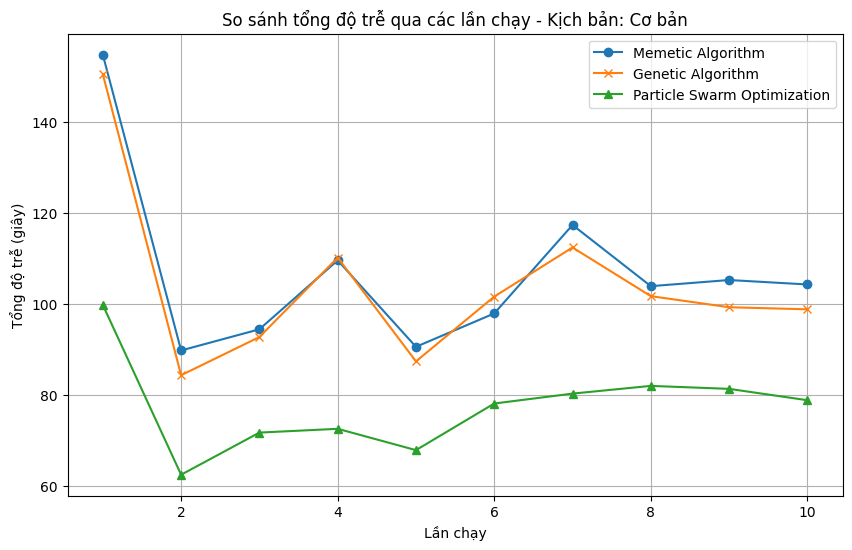


=== Kịch bản: Tăng số tác vụ ===
Đang chạy mô phỏng 1/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 2/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 3/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 4/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 5/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 6/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 7/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 8/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 9/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 10/10 cho kịch bản Tăng số tác vụ

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 226.97 giây
Genetic Algorithm: 231.70 giây
Particle Swarm Optimization: 167.72 giây


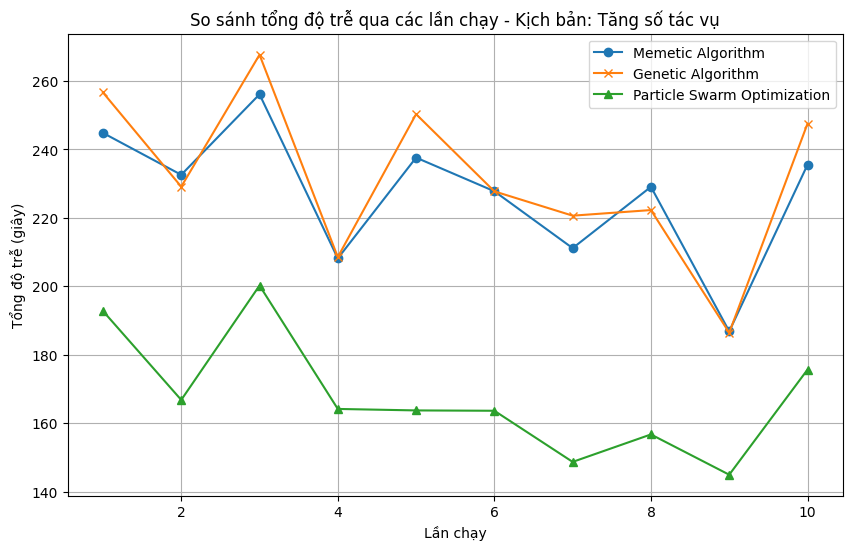


=== Kịch bản: Tăng số nút fog ===
Đang chạy mô phỏng 1/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 2/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 3/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 4/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 5/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 6/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 7/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 8/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 9/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 10/10 cho kịch bản Tăng số nút fog

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 107.10 giây
Genetic Algorithm: 106.44 giây
Particle Swarm Optimization: 76.32 giây


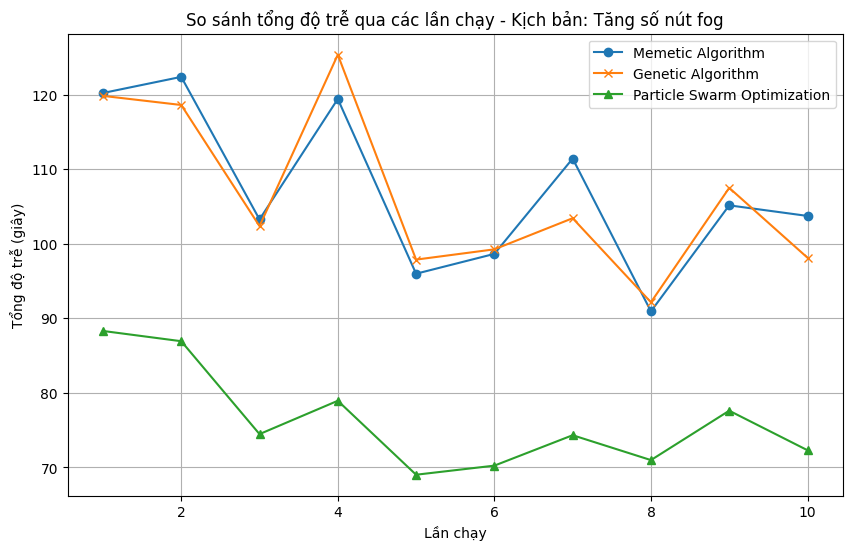

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Thiết lập tham số mô phỏng
POP_SIZE = 50       # Kích thước quần thể
CROSSOVER_RATE = 0.8  # Tỷ lệ lai ghép
MUTATION_RATE = 0.2   # Tỷ lệ đột biến
MAX_GENERATIONS = 100  # Số thế hệ tối đa
CPU_THRESHOLD = 0.8   # Ngưỡng quá tải CPU
NUM_RUNS = 10         # Số lần chạy độc lập

# Các tham số cho PSO
NUM_PARTICLES = 50    # Số hạt trong PSO
W = 0.5               # Hệ số quán tính (inertia weight)
C1 = 1.5              # Hệ số học từ pbest (cognitive)
C2 = 1.5              # Hệ số học từ gbest (social)

# Các kịch bản mô phỏng
SCENARIOS = [
    {"name": "Cơ bản", "NUM_FOG_NODES": 10, "NUM_TASKS": 50},
    {"name": "Tăng số tác vụ", "NUM_FOG_NODES": 10, "NUM_TASKS": 100},
    {"name": "Tăng số nút fog", "NUM_FOG_NODES": 20, "NUM_TASKS": 50},
]

# Lớp FogNode
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

# Lớp Task
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10

# Khởi tạo hệ thống
def initialize_system(num_fog_nodes, num_tasks):
    fog_nodes = [FogNode(i, random.uniform(1000, 5000), random.uniform(10, 50))
                 for i in range(num_fog_nodes)]
    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9))
             for i in range(num_tasks)]
    return fog_nodes, tasks

# Tính độ trễ hoàn thành
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# Tính fitness (tổng độ trễ)
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

# Khởi tạo quần thể
def initialize_population(popsize, num_tasks, num_fog_nodes):
    return [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]

# Lai ghép
def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# Đột biến
def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

# Chọn lọc
def select(population, fitnesses):
    weights = [1 / (f + 1e-6) for f in fitnesses]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    return random.choices(population, weights=weights, k=1)[0]

# Thuật toán Genetic Algorithm (GA)
def genetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitnesses = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            new_population.extend([child1, child2])
        population = new_population
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Tìm kiếm cục bộ (Memetic)
def local_search(individual, fog_nodes, tasks):
    best_individual = individual[:]
    best_fitness = fitness_function(best_individual, fog_nodes, tasks)
    for _ in range(3):
        neighbor = best_individual[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        neighbor_fitness = fitness_function(neighbor, fog_nodes, tasks)
        if neighbor_fitness < best_fitness:
            best_individual = neighbor[:]
            best_fitness = neighbor_fitness
    return best_individual

# Tái phân bổ tác vụ
def reassign_tasks(individual, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
        node.current_tasks = [tasks[i] for i, node_id in enumerate(individual) if node_id == node.id]
        node.current_cpu_load = sum(task.computation_size for task in node.current_tasks)
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        if cpu_usage > CPU_THRESHOLD and node.current_tasks:
            underloaded_nodes = [n for n in fog_nodes if (n.current_cpu_load / n.cpu_capacity) < 0.5]
            if underloaded_nodes:
                task_to_move = node.current_tasks[-1]
                task_idx = tasks.index(task_to_move)
                target_node = min(underloaded_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
                individual[task_idx] = target_node.id
    return individual

# Thuật toán Memetic Algorithm (MA)
def memetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitness_values = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            child1 = local_search(child1, fog_nodes, tasks)
            child2 = local_search(child2, fog_nodes, tasks)
            new_population.extend([child1, child2])
        population = [reassign_tasks(ind, fog_nodes, tasks) for ind in new_population]
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Thuật toán Particle Swarm Optimization (PSO) tối ưu cho bài toán rời rạc
def particle_swarm_optimization(num_particles, num_fog_nodes, num_tasks, fog_nodes, tasks, max_iterations=100):
    # Khởi tạo bầy hạt
    particles = initialize_population(num_particles, num_tasks, num_fog_nodes)
    velocities = [[0 for _ in range(num_tasks)] for _ in range(num_particles)]  # Vận tốc ban đầu
    pbest_positions = [particle[:] for particle in particles]
    pbest_fitnesses = [fitness_function(p, fog_nodes, tasks) for p in particles]
    gbest_idx = np.argmin(pbest_fitnesses)
    gbest_position = pbest_positions[gbest_idx][:]

    # Lặp qua các thế hệ
    for _ in range(max_iterations):
        for i in range(num_particles):
            # Cập nhật vận tốc (xác suất thay đổi)
            for j in range(num_tasks):
                r1 = random.random()
                r2 = random.random()
                velocity = (W * velocities[i][j] +
                            C1 * r1 * (1 if pbest_positions[i][j] != particles[i][j] else 0) +
                            C2 * r2 * (1 if gbest_position[j] != particles[i][j] else 0))
                velocities[i][j] = max(0, min(1, velocity))  # Giới hạn xác suất trong [0, 1]

            # Cập nhật vị trí
            new_position = particles[i][:]
            for j in range(num_tasks):
                if random.random() < velocities[i][j]:
                    # Chọn ngẫu nhiên giữa giá trị của pbest và gbest
                    if random.random() < 0.5:
                        new_position[j] = pbest_positions[i][j]
                    else:
                        new_position[j] = gbest_position[j]
                # Đột biến ngẫu nhiên nhỏ để tăng tính đa dạng
                if random.random() < 0.1:
                    new_position[j] = random.randint(0, num_fog_nodes - 1)

            # Đánh giá fitness
            new_fitness = fitness_function(new_position, fog_nodes, tasks)

            # Cập nhật pbest
            if new_fitness < pbest_fitnesses[i]:
                pbest_positions[i] = new_position[:]
                pbest_fitnesses[i] = new_fitness

            # Cập nhật gbest
            if new_fitness < fitness_function(gbest_position, fog_nodes, tasks):
                gbest_position = new_position[:]

            particles[i] = new_position[:]

    # Tái phân bổ tác vụ cho giải pháp tốt nhất từ PSO
    gbest_position = reassign_tasks(gbest_position, fog_nodes, tasks)
    return fitness_function(gbest_position, fog_nodes, tasks)

# Chạy mô phỏng cho từng kịch bản
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Kịch bản: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]

        ma_latencies = []
        ga_latencies = []
        pso_latencies = []

        for run in range(NUM_RUNS):
            print(f"Đang chạy mô phỏng {run + 1}/{NUM_RUNS} cho kịch bản {scenario['name']}")
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks)

            # Chạy Memetic Algorithm
            ma_fitness = memetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ma_latencies.append(ma_fitness)

            # Chạy Genetic Algorithm
            ga_fitness = genetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ga_latencies.append(ga_fitness)

            # Chạy Particle Swarm Optimization
            pso_fitness = particle_swarm_optimization(
                NUM_PARTICLES, num_fog_nodes, num_tasks, fog_nodes, tasks, max_iterations=MAX_GENERATIONS
            )
            pso_latencies.append(pso_fitness)

        # In kết quả trung bình
        print(f"\nĐộ trễ hoàn thành trung bình qua {NUM_RUNS} lần chạy:")
        print(f"Memetic Algorithm: {np.mean(ma_latencies):.2f} giây")
        print(f"Genetic Algorithm: {np.mean(ga_latencies):.2f} giây")
        print(f"Particle Swarm Optimization: {np.mean(pso_latencies):.2f} giây")

        # Vẽ biểu đồ so sánh
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, NUM_RUNS + 1), ma_latencies, label="Memetic Algorithm", marker='o')
        plt.plot(range(1, NUM_RUNS + 1), ga_latencies, label="Genetic Algorithm", marker='x')
        plt.plot(range(1, NUM_RUNS + 1), pso_latencies, label="Particle Swarm Optimization", marker='^')
        plt.xlabel("Lần chạy")
        plt.ylabel("Tổng độ trễ (giây)")
        plt.title(f"So sánh tổng độ trễ qua các lần chạy - Kịch bản: {scenario['name']}")
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()

In [ ]:
thay pso bằng robin


=== Kịch bản: Cơ bản ===
Đang chạy mô phỏng 1/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 2/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 3/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 4/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 5/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 6/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 7/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 8/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 9/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 10/10 cho kịch bản Cơ bản

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 108.87 giây
Genetic Algorithm: 105.43 giây
Round-Robin: 122.40 giây


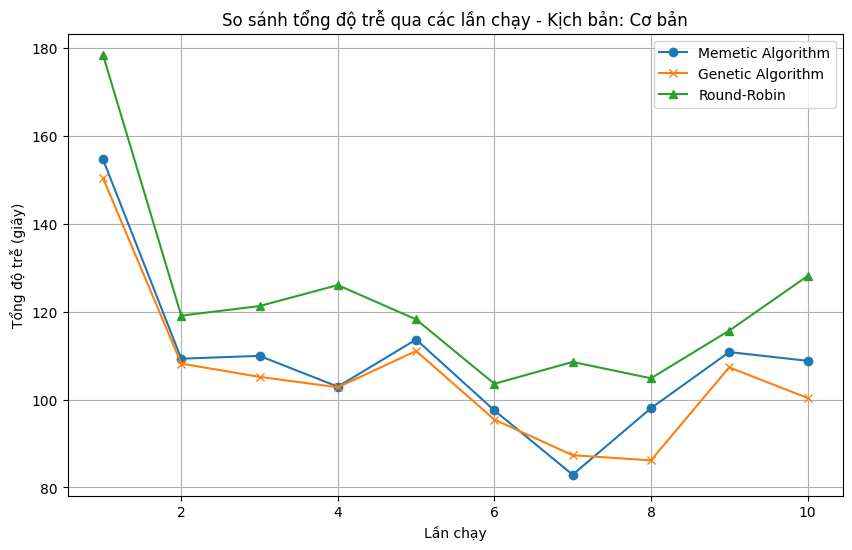


=== Kịch bản: Tăng số tác vụ ===
Đang chạy mô phỏng 1/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 2/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 3/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 4/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 5/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 6/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 7/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 8/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 9/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 10/10 cho kịch bản Tăng số tác vụ

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 221.74 giây
Genetic Algorithm: 226.42 giây
Round-Robin: 257.69 giây


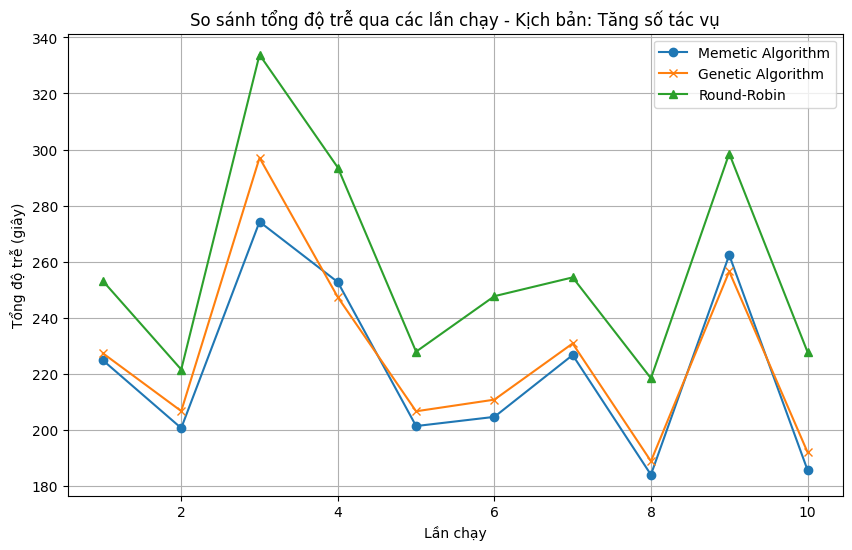


=== Kịch bản: Tăng số nút fog ===
Đang chạy mô phỏng 1/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 2/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 3/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 4/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 5/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 6/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 7/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 8/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 9/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 10/10 cho kịch bản Tăng số nút fog

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 107.01 giây
Genetic Algorithm: 104.75 giây
Round-Robin: 124.77 giây


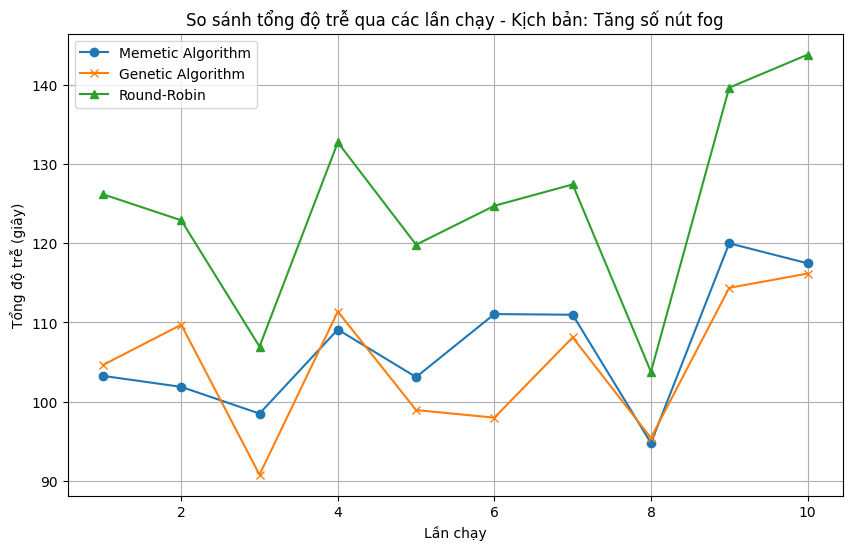

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Thiết lập tham số mô phỏng
POP_SIZE = 50       # Kích thước quần thể
CROSSOVER_RATE = 0.8  # Tỷ lệ lai ghép
MUTATION_RATE = 0.2   # Tỷ lệ đột biến
MAX_GENERATIONS = 100  # Số thế hệ tối đa
CPU_THRESHOLD = 0.8   # Ngưỡng quá tải CPU
NUM_RUNS = 10         # Số lần chạy độc lập

# Các kịch bản mô phỏng
SCENARIOS = [
    {"name": "Cơ bản", "NUM_FOG_NODES": 10, "NUM_TASKS": 50},
    {"name": "Tăng số tác vụ", "NUM_FOG_NODES": 10, "NUM_TASKS": 100},
    {"name": "Tăng số nút fog", "NUM_FOG_NODES": 20, "NUM_TASKS": 50},
]

# Lớp FogNode
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

# Lớp Task
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10

# Khởi tạo hệ thống
def initialize_system(num_fog_nodes, num_tasks):
    fog_nodes = [FogNode(i, random.uniform(1000, 5000), random.uniform(10, 50))
                 for i in range(num_fog_nodes)]
    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9))
             for i in range(num_tasks)]
    return fog_nodes, tasks

# Tính độ trễ hoàn thành
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# Tính fitness (tổng độ trễ)
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

# Khởi tạo quần thể
def initialize_population(popsize, num_tasks, num_fog_nodes):
    return [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]

# Lai ghép
def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# Đột biến
def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

# Chọn lọc
def select(population, fitnesses):
    weights = [1 / (f + 1e-6) for f in fitnesses]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    return random.choices(population, weights=weights, k=1)[0]

# Thuật toán Genetic Algorithm (GA)
def genetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitnesses = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            new_population.extend([child1, child2])
        population = new_population
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Tìm kiếm cục bộ (Memetic)
def local_search(individual, fog_nodes, tasks):
    best_individual = individual[:]
    best_fitness = fitness_function(best_individual, fog_nodes, tasks)
    for _ in range(3):
        neighbor = best_individual[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        neighbor_fitness = fitness_function(neighbor, fog_nodes, tasks)
        if neighbor_fitness < best_fitness:
            best_individual = neighbor[:]
            best_fitness = neighbor_fitness
    return best_individual

# Tái phân bổ tác vụ
def reassign_tasks(individual, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
        node.current_tasks = [tasks[i] for i, node_id in enumerate(individual) if node_id == node.id]
        node.current_cpu_load = sum(task.computation_size for task in node.current_tasks)
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        if cpu_usage > CPU_THRESHOLD and node.current_tasks:
            underloaded_nodes = [n for n in fog_nodes if (n.current_cpu_load / n.cpu_capacity) < 0.5]
            if underloaded_nodes:
                task_to_move = node.current_tasks[-1]
                task_idx = tasks.index(task_to_move)
                target_node = min(underloaded_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
                individual[task_idx] = target_node.id
    return individual

# Thuật toán Memetic Algorithm (MA)
def memetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitness_values = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            child1 = local_search(child1, fog_nodes, tasks)
            child2 = local_search(child2, fog_nodes, tasks)
            new_population.extend([child1, child2])
        population = [reassign_tasks(ind, fog_nodes, tasks) for ind in new_population]
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Thuật toán Round-Robin
def round_robin_assignment(num_tasks, num_fog_nodes):
    """
    Tạo giải pháp phân bổ tác vụ theo Round-Robin.

    :param num_tasks: Số lượng tác vụ
    :param num_fog_nodes: Số lượng nút fog
    :return: Danh sách biểu thị nút fog được gán cho mỗi tác vụ
    """
    return [i % num_fog_nodes for i in range(num_tasks)]

# Chạy mô phỏng cho từng kịch bản
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Kịch bản: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]

        ma_latencies = []
        ga_latencies = []
        rr_latencies = []  # Lưu độ trễ của Round-Robin

        for run in range(NUM_RUNS):
            print(f"Đang chạy mô phỏng {run + 1}/{NUM_RUNS} cho kịch bản {scenario['name']}")
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks)

            # Chạy Memetic Algorithm
            ma_fitness = memetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ma_latencies.append(ma_fitness)

            # Chạy Genetic Algorithm
            ga_fitness = genetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ga_latencies.append(ga_fitness)

            # Chạy Round-Robin
            rr_solution = round_robin_assignment(num_tasks, num_fog_nodes)
            rr_fitness = fitness_function(rr_solution, fog_nodes, tasks)
            rr_latencies.append(rr_fitness)

        # In kết quả trung bình
        print(f"\nĐộ trễ hoàn thành trung bình qua {NUM_RUNS} lần chạy:")
        print(f"Memetic Algorithm: {np.mean(ma_latencies):.2f} giây")
        print(f"Genetic Algorithm: {np.mean(ga_latencies):.2f} giây")
        print(f"Round-Robin: {np.mean(rr_latencies):.2f} giây")

        # Vẽ biểu đồ so sánh
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, NUM_RUNS + 1), ma_latencies, label="Memetic Algorithm", marker='o')
        plt.plot(range(1, NUM_RUNS + 1), ga_latencies, label="Genetic Algorithm", marker='x')
        plt.plot(range(1, NUM_RUNS + 1), rr_latencies, label="Round-Robin", marker='^')
        plt.xlabel("Lần chạy")
        plt.ylabel("Tổng độ trễ (giây)")
        plt.title(f"So sánh tổng độ trễ qua các lần chạy - Kịch bản: {scenario['name']}")
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()

đổi tên, màu 3d


=== Kịch bản: Cơ bản ===
Đang chạy mô phỏng 1/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 2/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 3/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 4/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 5/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 6/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 7/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 8/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 9/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 10/10 cho kịch bản Cơ bản

Tổng thời gian hoàn thành tác vụ trung bình qua 10 lần chạy:
Memetic Algorithm: 108.87 giây
Genetic Algorithm: 105.43 giây
Round-Robin: 122.40 giây

=== Kịch bản: Tăng số tác vụ ===
Đang chạy mô phỏng 1/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 2/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 3/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 4/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 5/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 6/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 7/10 cho kịch bản T

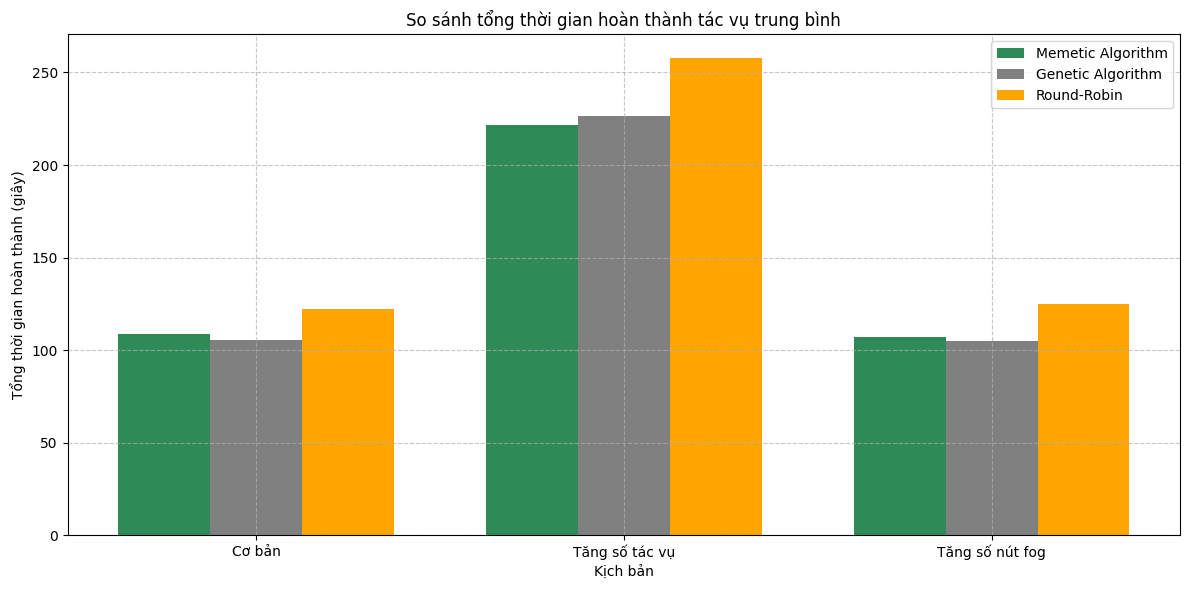

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Thiết lập tham số mô phỏng
POP_SIZE = 50       # Kích thước quần thể
CROSSOVER_RATE = 0.8  # Tỷ lệ lai ghép
MUTATION_RATE = 0.2   # Tỷ lệ đột biến
MAX_GENERATIONS = 100  # Số thế hệ tối đa
CPU_THRESHOLD = 0.8   # Ngưỡng quá tải CPU
NUM_RUNS = 10         # Số lần chạy độc lập

# Các kịch bản mô phỏng
SCENARIOS = [
    {"name": "Cơ bản", "NUM_FOG_NODES": 10, "NUM_TASKS": 50},
    {"name": "Tăng số tác vụ", "NUM_FOG_NODES": 10, "NUM_TASKS": 100},
    {"name": "Tăng số nút fog", "NUM_FOG_NODES": 20, "NUM_TASKS": 50},
]

# Lớp FogNode
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

# Lớp Task
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10

# Khởi tạo hệ thống
def initialize_system(num_fog_nodes, num_tasks):
    fog_nodes = [FogNode(i, random.uniform(1000, 5000), random.uniform(10, 50))
                 for i in range(num_fog_nodes)]
    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9))
             for i in range(num_tasks)]
    return fog_nodes, tasks

# Tính thời gian hoàn thành của một nút
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# Tính tổng thời gian hoàn thành tác vụ
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

# Khởi tạo quần thể
def initialize_population(popsize, num_tasks, num_fog_nodes):
    return [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]

# Lai ghép
def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# Đột biến
def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

# Chọn lọc
def select(population, fitnesses):
    weights = [1 / (f + 1e-6) for f in fitnesses]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    return random.choices(population, weights=weights, k=1)[0]

# Thuật toán Genetic Algorithm (GA)
def genetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitnesses = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            new_population.extend([child1, child2])
        population = new_population
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Tìm kiếm cục bộ (Memetic)
def local_search(individual, fog_nodes, tasks):
    best_individual = individual[:]
    best_fitness = fitness_function(best_individual, fog_nodes, tasks)
    for _ in range(3):
        neighbor = best_individual[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        neighbor_fitness = fitness_function(neighbor, fog_nodes, tasks)
        if neighbor_fitness < best_fitness:
            best_individual = neighbor[:]
            best_fitness = neighbor_fitness
    return best_individual

# Tái phân bổ tác vụ
def reassign_tasks(individual, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
        node.current_tasks = [tasks[i] for i, node_id in enumerate(individual) if node_id == node.id]
        node.current_cpu_load = sum(task.computation_size for task in node.current_tasks)
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        if cpu_usage > CPU_THRESHOLD and node.current_tasks:
            underloaded_nodes = [n for n in fog_nodes if (n.current_cpu_load / n.cpu_capacity) < 0.5]
            if underloaded_nodes:
                task_to_move = node.current_tasks[-1]
                task_idx = tasks.index(task_to_move)
                target_node = min(underloaded_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
                individual[task_idx] = target_node.id
    return individual

# Thuật toán Memetic Algorithm (MA)
def memetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitness_values = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            child1 = local_search(child1, fog_nodes, tasks)
            child2 = local_search(child2, fog_nodes, tasks)
            new_population.extend([child1, child2])
        population = [reassign_tasks(ind, fog_nodes, tasks) for ind in new_population]
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Thuật toán Round-Robin
def round_robin_assignment(num_tasks, num_fog_nodes):
    return [i % num_fog_nodes for i in range(num_tasks)]

# Chạy mô phỏng cho từng kịch bản
def run_simulation():
    # Lưu trữ kết quả trung bình của tất cả các kịch bản để vẽ biểu đồ
    all_ma_means = []
    all_ga_means = []
    all_rr_means = []
    scenario_names = []

    for scenario in SCENARIOS:
        print(f"\n=== Kịch bản: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]

        ma_latencies = []
        ga_latencies = []
        rr_latencies = []

        for run in range(NUM_RUNS):
            print(f"Đang chạy mô phỏng {run + 1}/{NUM_RUNS} cho kịch bản {scenario['name']}")
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks)

            # Chạy Memetic Algorithm
            ma_fitness = memetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ma_latencies.append(ma_fitness)

            # Chạy Genetic Algorithm
            ga_fitness = genetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ga_latencies.append(ga_fitness)

            # Chạy Round-Robin
            rr_solution = round_robin_assignment(num_tasks, num_fog_nodes)
            rr_fitness = fitness_function(rr_solution, fog_nodes, tasks)
            rr_latencies.append(rr_fitness)

        # Tính trung bình và lưu kết quả
        ma_mean = np.mean(ma_latencies)
        ga_mean = np.mean(ga_latencies)
        rr_mean = np.mean(rr_latencies)
        all_ma_means.append(ma_mean)
        all_ga_means.append(ga_mean)
        all_rr_means.append(rr_mean)
        scenario_names.append(scenario['name'])

        # In kết quả trung bình
        print(f"\nTổng thời gian hoàn thành tác vụ trung bình qua {NUM_RUNS} lần chạy:")
        print(f"Memetic Algorithm: {ma_mean:.2f} giây")
        print(f"Genetic Algorithm: {ga_mean:.2f} giây")
        print(f"Round-Robin: {rr_mean:.2f} giây")

    # Vẽ biểu đồ cột 2D
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(SCENARIOS))  # Vị trí trên trục x cho các kịch bản
    bar_width = 0.25  # Độ rộng của cột

    # Vẽ cột cho từng thuật toán
    ax.bar(x - bar_width, all_ma_means, bar_width, label='Memetic Algorithm', color='blue')
    ax.bar(x, all_ga_means, bar_width, label='Genetic Algorithm', color='gray')
    ax.bar(x + bar_width, all_rr_means, bar_width, label='Round-Robin', color='orange')

    # Thiết lập nhãn và tiêu đề
    ax.set_xlabel('Kịch bản')
    ax.set_ylabel('Tổng thời gian hoàn thành (giây)')
    ax.set_title('So sánh tổng thời gian hoàn thành tác vụ trung bình')
    ax.set_xticks(x)
    ax.set_xticklabels(scenario_names)
    ax.legend()

    # Thêm lưới cho dễ đọc
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()

VIẾT LẠI CODE CHO CÁC KỊCH BẢN ( 3 KỊCH BẢN ĐẦU)


=== Kịch bản: Cơ bản ===
Đang chạy mô phỏng 1/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 2/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 3/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 4/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 5/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 6/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 7/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 8/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 9/10 cho kịch bản Cơ bản
Đang chạy mô phỏng 10/10 cho kịch bản Cơ bản

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 458.64 giây
Genetic Algorithm: 468.48 giây
Round-Robin: 496.95 giây


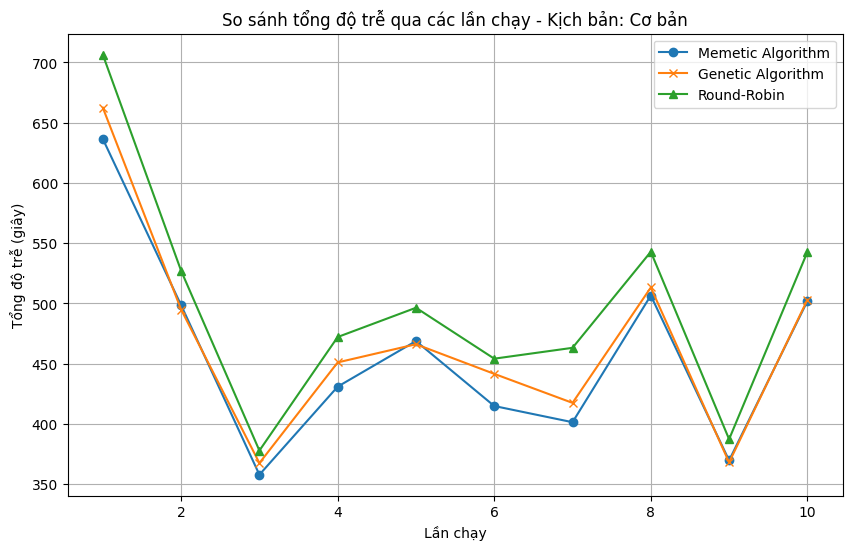


=== Kịch bản: Tăng số tác vụ ===
Đang chạy mô phỏng 1/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 2/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 3/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 4/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 5/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 6/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 7/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 8/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 9/10 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 10/10 cho kịch bản Tăng số tác vụ

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 923.33 giây
Genetic Algorithm: 924.16 giây
Round-Robin: 978.10 giây


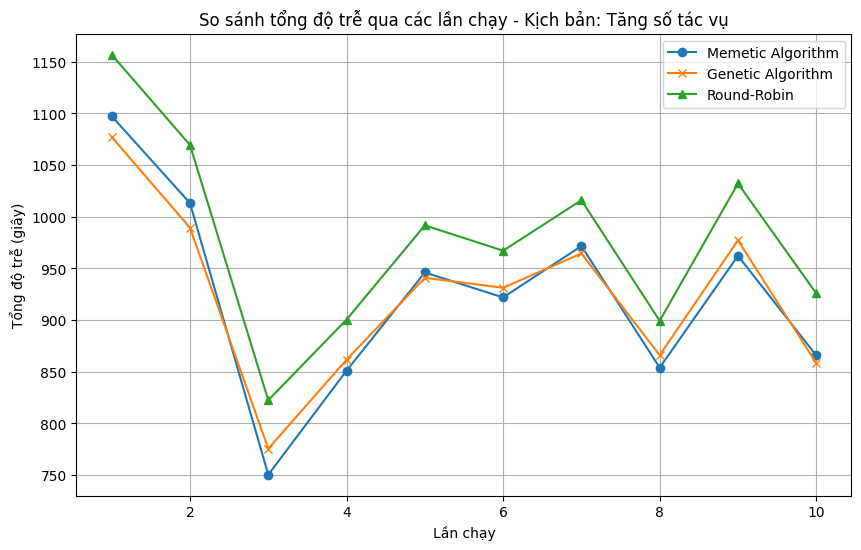


=== Kịch bản: Tăng số nút fog ===
Đang chạy mô phỏng 1/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 2/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 3/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 4/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 5/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 6/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 7/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 8/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 9/10 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 10/10 cho kịch bản Tăng số nút fog

Độ trễ hoàn thành trung bình qua 10 lần chạy:
Memetic Algorithm: 451.28 giây
Genetic Algorithm: 461.03 giây
Round-Robin: 497.32 giây


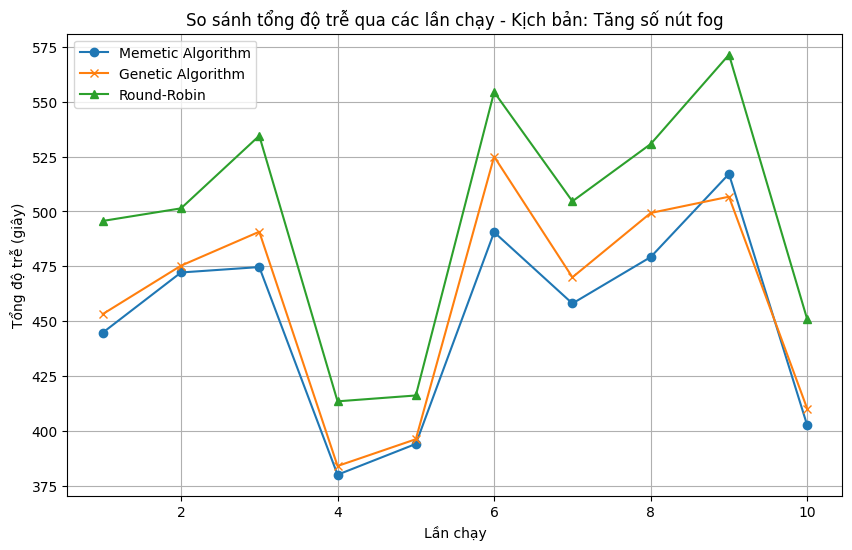

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Tham số mô phỏng
POP_SIZE = 50         # Kích thước quần thể
CROSSOVER_RATE = 0.8  # Tỷ lệ lai ghép
MUTATION_RATE = 0.2   # Tỷ lệ đột biến
MAX_GENERATIONS = 100 # Số thế hệ tối đa
CPU_THRESHOLD = 0.8   # Ngưỡng quá tải CPU
NUM_RUNS = 10         # Số lần chạy độc lập

# Định nghĩa các kịch bản mô phỏng (3 kịch bản đầu tiên)
SCENARIOS = [
    {"name": "Cơ bản", "NUM_FOG_NODES": 10, "NUM_TASKS": 200},
    {"name": "Tăng số tác vụ", "NUM_FOG_NODES": 10, "NUM_TASKS": 400},
    {"name": "Tăng số nút fog", "NUM_FOG_NODES": 20, "NUM_TASKS": 200},
]

# Lớp đại diện cho node fog
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity  # Dung lượng CPU (MIPS)
        self.bandwidth = bandwidth        # Băng thông (Mbps)
        self.current_cpu_load = 0         # Tải CPU hiện tại
        self.current_tasks = []           # Danh sách tác vụ được gán

    def reset_load(self):
        """Đặt lại tải CPU và danh sách tác vụ"""
        self.current_cpu_load = 0
        self.current_tasks = []

# Lớp đại diện cho tác vụ
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size          # Kích thước dữ liệu (MB)
        self.processing_time = processing_time  # Thời gian xử lý (giây)
        self.priority = priority            # Độ ưu tiên
        self.computation_size = data_size * 10  # Kích thước tính toán (MI)

# Khởi tạo hệ thống với node fog và tác vụ
def initialize_system(num_fog_nodes, num_tasks):
    fog_nodes = [FogNode(i, random.uniform(1000, 5000), random.uniform(10, 50))
                 for i in range(num_fog_nodes)]
    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9))
             for i in range(num_tasks)]
    return fog_nodes, tasks

# Tính độ trễ hoàn thành cho một node
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# Hàm đánh giá (tổng độ trễ)
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

# Khởi tạo quần thể ban đầu
def initialize_population(popsize, num_tasks, num_fog_nodes):
    return [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)]
            for _ in range(popsize)]

# Lai ghép giữa hai cá thể
def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# Đột biến trên một cá thể
def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

# Chọn cá thể dựa trên fitness
def select(population, fitnesses):
    weights = [1 / (f + 1e-6) for f in fitnesses]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    return random.choices(population, weights=weights, k=1)[0]

# Thuật toán di truyền
def genetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitnesses = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            new_population.extend([child1, child2])
        population = new_population
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Tìm kiếm cục bộ
def local_search(individual, fog_nodes, tasks):
    best_individual = individual[:]
    best_fitness = fitness_function(best_individual, fog_nodes, tasks)
    for _ in range(3):
        neighbor = best_individual[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        neighbor_fitness = fitness_function(neighbor, fog_nodes, tasks)
        if neighbor_fitness < best_fitness:
            best_individual = neighbor[:]
            best_fitness = neighbor_fitness
    return best_individual

# Thuật toán Memetic
def memetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitness_values = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            child1 = local_search(child1, fog_nodes, tasks)
            child2 = local_search(child2, fog_nodes, tasks)
            new_population.extend([child1, child2])
        population = new_population
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Phân bổ tác vụ theo Round-Robin
def round_robin_assignment(num_tasks, num_fog_nodes):
    return [i % num_fog_nodes for i in range(num_tasks)]

# Chạy mô phỏng
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Kịch bản: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]

        ma_latencies = []
        ga_latencies = []
        rr_latencies = []

        for run in range(NUM_RUNS):
            print(f"Đang chạy mô phỏng {run + 1}/{NUM_RUNS} cho kịch bản {scenario['name']}")
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks)

            # Chạy Memetic Algorithm
            ma_fitness = memetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ma_latencies.append(ma_fitness)

            # Chạy Genetic Algorithm
            ga_fitness = genetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ga_latencies.append(ga_fitness)

            # Chạy Round-Robin
            rr_solution = round_robin_assignment(num_tasks, num_fog_nodes)
            rr_fitness = fitness_function(rr_solution, fog_nodes, tasks)
            rr_latencies.append(rr_fitness)

        # In kết quả trung bình
        print(f"\nĐộ trễ hoàn thành trung bình qua {NUM_RUNS} lần chạy:")
        print(f"Memetic Algorithm: {np.mean(ma_latencies):.2f} giây")
        print(f"Genetic Algorithm: {np.mean(ga_latencies):.2f} giây")
        print(f"Round-Robin: {np.mean(rr_latencies):.2f} giây")

        # Vẽ biểu đồ so sánh
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, NUM_RUNS + 1), ma_latencies, label="Memetic Algorithm", marker='o')
        plt.plot(range(1, NUM_RUNS + 1), ga_latencies, label="Genetic Algorithm", marker='x')
        plt.plot(range(1, NUM_RUNS + 1), rr_latencies, label="Round-Robin", marker='^')
        plt.xlabel("Lần chạy")
        plt.ylabel("Tổng độ trễ (giây)")
        plt.title(f"So sánh tổng độ trễ qua các lần chạy - Kịch bản: {scenario['name']}")
        plt.legend()
        plt.grid(True)
        plt.show()

# Chạy chương trình
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()

KỊCH BẢN VỚI NÚT BỊ QUÁ TẢI


=== Kịch bản: Cơ bản ===
Đang chạy mô phỏng 1/5 cho kịch bản Cơ bản
Đang chạy mô phỏng 2/5 cho kịch bản Cơ bản
Đang chạy mô phỏng 3/5 cho kịch bản Cơ bản
Đang chạy mô phỏng 4/5 cho kịch bản Cơ bản
Đang chạy mô phỏng 5/5 cho kịch bản Cơ bản

Độ trễ hoàn thành trung bình qua 5 lần chạy:
Memetic Algorithm: 221.63 giây
Genetic Algorithm: 234.09 giây
Round-Robin: 258.38 giây


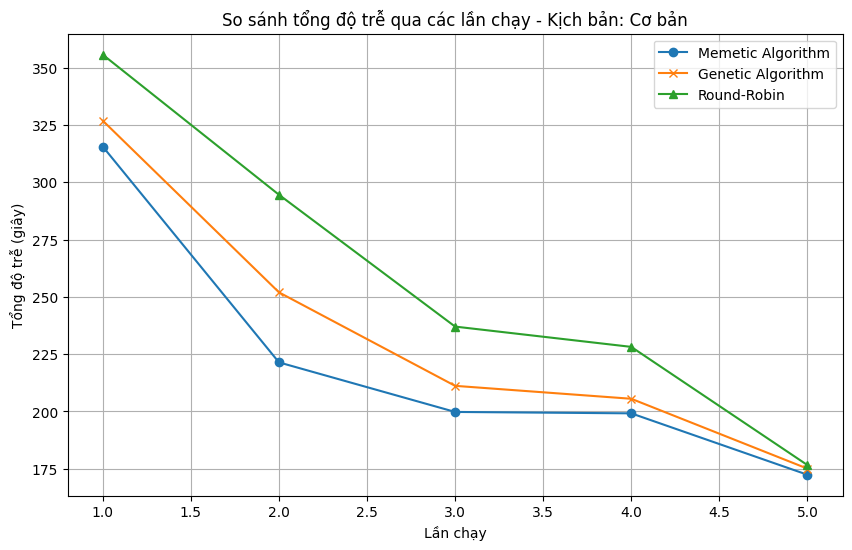


=== Kịch bản: Tăng số tác vụ ===
Đang chạy mô phỏng 1/5 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 2/5 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 3/5 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 4/5 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 5/5 cho kịch bản Tăng số tác vụ

Độ trễ hoàn thành trung bình qua 5 lần chạy:
Memetic Algorithm: 450.64 giây
Genetic Algorithm: 461.03 giây
Round-Robin: 502.13 giây


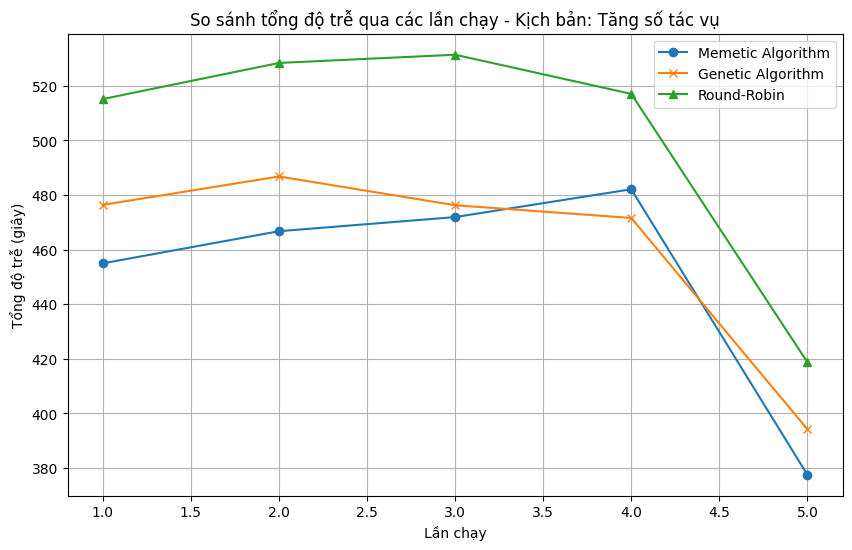


=== Kịch bản: Tăng số nút fog ===
Đang chạy mô phỏng 1/5 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 2/5 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 3/5 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 4/5 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 5/5 cho kịch bản Tăng số nút fog

Độ trễ hoàn thành trung bình qua 5 lần chạy:
Memetic Algorithm: 222.99 giây
Genetic Algorithm: 228.74 giây
Round-Robin: 254.01 giây


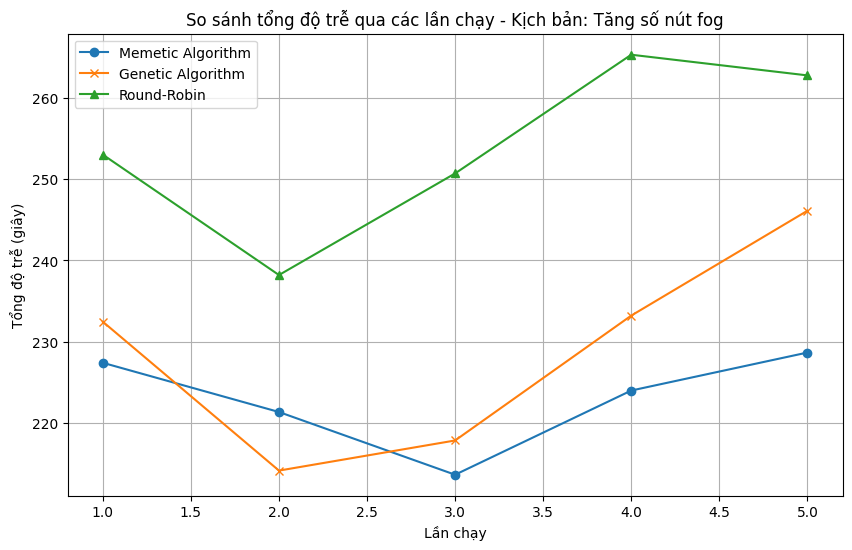


=== Kịch bản: Node quá tải ===
Đang chạy mô phỏng 1/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:
Node 4 quá tải với CPU usage: 1.13
Đang chạy mô phỏng 2/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:
Đang chạy mô phỏng 3/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:
Đang chạy mô phỏng 4/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:
Node 3 quá tải với CPU usage: 0.80
Đang chạy mô phỏng 5/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:

Độ trễ hoàn thành trung bình qua 5 lần chạy:
Memetic Algorithm: 16.85 giây
Genetic Algorithm: 17.08 giây
Round-Robin: 22.32 giây


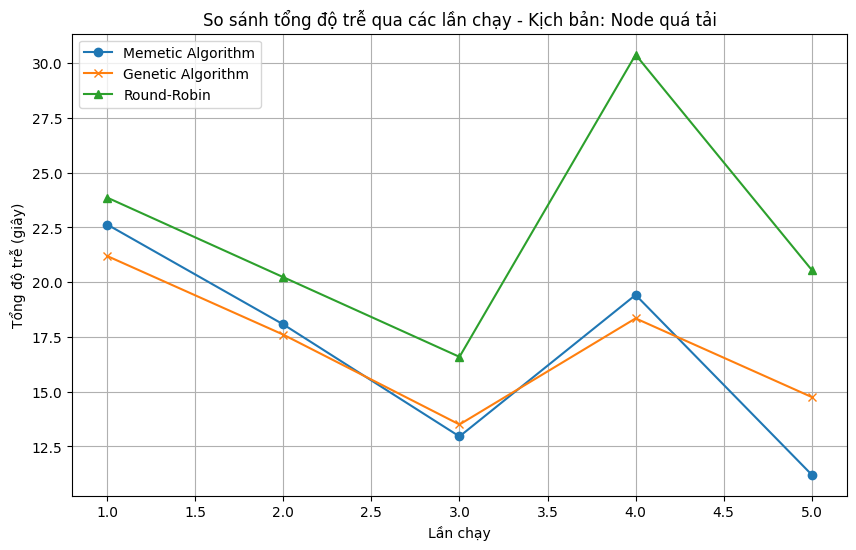

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Tham số mô phỏng
POP_SIZE = 50         # Kích thước quần thể
CROSSOVER_RATE = 0.8  # Tỷ lệ lai ghép
MUTATION_RATE = 0.2   # Tỷ lệ đột biến
MAX_GENERATIONS = 100 # Số thế hệ tối đa
CPU_THRESHOLD = 0.8   # Ngưỡng quá tải CPU
NUM_RUNS = 5         # Số lần chạy độc lập

# Định nghĩa các kịch bản mô phỏng (bao gồm kịch bản thứ tư)
SCENARIOS = [
    {"name": "Cơ bản", "NUM_FOG_NODES": 5, "NUM_TASKS": 100},
    {"name": "Tăng số tác vụ", "NUM_FOG_NODES": 20, "NUM_TASKS": 200},
    {"name": "Tăng số nút fog", "NUM_FOG_NODES": 30, "NUM_TASKS": 100},
    {"name": "Node quá tải", "NUM_FOG_NODES": 5, "NUM_TASKS": 10}  # Kịch bản có node quá tải
]

# Lớp đại diện cho node fog
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        """Đặt lại tải CPU và danh sách tác vụ"""
        self.current_cpu_load = 0
        self.current_tasks = []

# Lớp đại diện cho tác vụ
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10

# Khởi tạo hệ thống
def initialize_system(num_fog_nodes, num_tasks):
    fog_nodes = [FogNode(i, random.uniform(1000, 5000), random.uniform(10, 50))
                 for i in range(num_fog_nodes)]
    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9))
             for i in range(num_tasks)]
    return fog_nodes, tasks

# Tính độ trễ hoàn thành
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# Hàm đánh giá
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

# Khởi tạo quần thể
def initialize_population(popsize, num_tasks, num_fog_nodes):
    return [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)]
            for _ in range(popsize)]

# Lai ghép
def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# Đột biến
def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

# Chọn cá thể
def select(population, fitnesses):
    weights = [1 / (f + 1e-6) for f in fitnesses]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    return random.choices(population, weights=weights, k=1)[0]

# Thuật toán di truyền
def genetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitnesses = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            new_population.extend([child1, child2])
        population = new_population
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Tìm kiếm cục bộ
def local_search(individual, fog_nodes, tasks):
    best_individual = individual[:]
    best_fitness = fitness_function(best_individual, fog_nodes, tasks)
    for _ in range(3):
        neighbor = best_individual[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        neighbor_fitness = fitness_function(neighbor, fog_nodes, tasks)
        if neighbor_fitness < best_fitness:
            best_individual = neighbor[:]
            best_fitness = neighbor_fitness
    return best_individual

# Tái phân bổ tác vụ để tránh quá tải
def reassign_tasks(individual, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
        node.current_tasks = [tasks[i] for i, node_id in enumerate(individual) if node_id == node.id]
        node.current_cpu_load = sum(task.computation_size for task in node.current_tasks)
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        if cpu_usage > CPU_THRESHOLD and node.current_tasks:
            underloaded_nodes = [n for n in fog_nodes if (n.current_cpu_load / n.cpu_capacity) < 0.5]
            if underloaded_nodes:
                task_to_move = node.current_tasks[-1]
                task_idx = tasks.index(task_to_move)
                target_node = min(underloaded_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
                individual[task_idx] = target_node.id
    return individual

# Thuật toán Memetic
def memetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitness_values = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            child1 = local_search(child1, fog_nodes, tasks)
            child2 = local_search(child2, fog_nodes, tasks)
            new_population.extend([child1, child2])
        population = [reassign_tasks(ind, fog_nodes, tasks) for ind in new_population]
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Phân bổ Round-Robin
def round_robin_assignment(num_tasks, num_fog_nodes):
    return [i % num_fog_nodes for i in range(num_tasks)]

# Kiểm tra node quá tải
def check_overload(fog_nodes):
    overloaded = False
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        if cpu_usage > CPU_THRESHOLD:
            print(f"Node {node.id} quá tải với CPU usage: {cpu_usage:.2f}")
            overloaded = True
    return overloaded

# Chạy mô phỏng
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Kịch bản: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]

        ma_latencies = []
        ga_latencies = []
        rr_latencies = []

        for run in range(NUM_RUNS):
            print(f"Đang chạy mô phỏng {run + 1}/{NUM_RUNS} cho kịch bản {scenario['name']}")
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks)

            # Chạy Memetic Algorithm
            ma_fitness = memetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ma_latencies.append(ma_fitness)

            # Chạy Genetic Algorithm
            ga_fitness = genetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ga_latencies.append(ga_fitness)

            # Chạy Round-Robin
            rr_solution = round_robin_assignment(num_tasks, num_fog_nodes)
            rr_fitness = fitness_function(rr_solution, fog_nodes, tasks)
            rr_latencies.append(rr_fitness)

            # Kiểm tra node quá tải trong kịch bản thứ tư
            if scenario["name"] == "Node quá tải":
                print("Kiểm tra node quá tải sau Round-Robin:")
                check_overload(fog_nodes)

        # In kết quả trung bình
        print(f"\nĐộ trễ hoàn thành trung bình qua {NUM_RUNS} lần chạy:")
        print(f"Memetic Algorithm: {np.mean(ma_latencies):.2f} giây")
        print(f"Genetic Algorithm: {np.mean(ga_latencies):.2f} giây")
        print(f"Round-Robin: {np.mean(rr_latencies):.2f} giây")

        # Vẽ biểu đồ
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, NUM_RUNS + 1), ma_latencies, label="Memetic Algorithm", marker='o')
        plt.plot(range(1, NUM_RUNS + 1), ga_latencies, label="Genetic Algorithm", marker='x')
        plt.plot(range(1, NUM_RUNS + 1), rr_latencies, label="Round-Robin", marker='^')
        plt.xlabel("Lần chạy")
        plt.ylabel("Tổng độ trễ (giây)")
        plt.title(f"So sánh tổng độ trễ qua các lần chạy - Kịch bản: {scenario['name']}")
        plt.legend()
        plt.grid(True)
        plt.show()

# Chạy chương trình
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()

thuật toán thêm độ tin cậy


=== Kịch bản: Cơ bản ===
Đang chạy mô phỏng 1/5 cho kịch bản Cơ bản
Đang chạy mô phỏng 2/5 cho kịch bản Cơ bản
Đang chạy mô phỏng 3/5 cho kịch bản Cơ bản
Đang chạy mô phỏng 4/5 cho kịch bản Cơ bản
Đang chạy mô phỏng 5/5 cho kịch bản Cơ bản

Đánh giá độ tin cậy qua 5 lần chạy:
Memetic Algorithm:
  - Trung bình: 217.90 giây
  - Độ lệch chuẩn: 46.06 giây
  - Khoảng tin cậy 95%: [153.96, 281.84] giây
Genetic Algorithm:
  - Trung bình: 218.40 giây
  - Độ lệch chuẩn: 47.98 giây
  - Khoảng tin cậy 95%: [151.79, 285.01] giây
Round-Robin:
  - Trung bình: 245.91 giây
  - Độ lệch chuẩn: 56.31 giây
  - Khoảng tin cậy 95%: [167.75, 324.08] giây

Kiểm định t-test (MA vs GA): t = -0.01, p-value = 0.9885
Kiểm định t-test (MA vs RR): t = -0.77, p-value = 0.4634


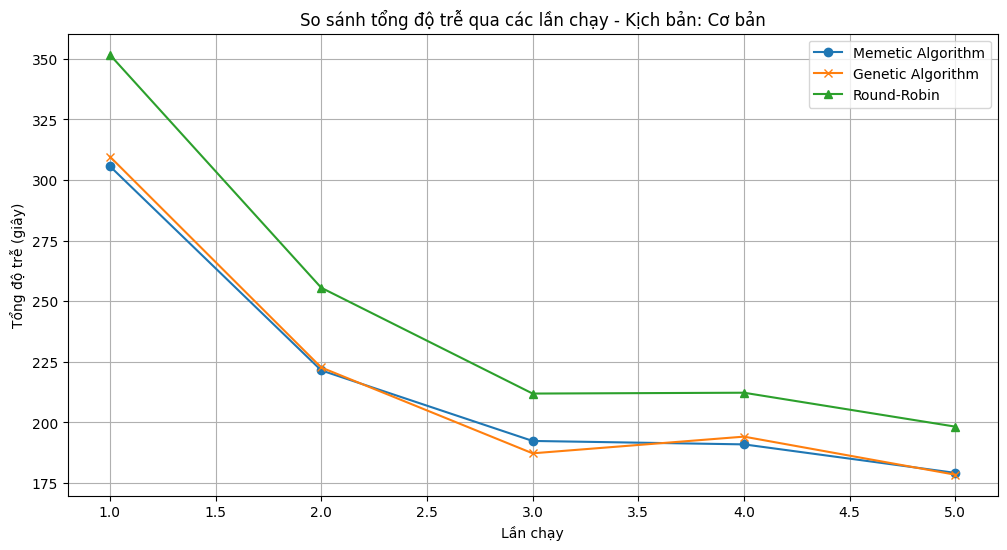

<ipython-input-5-d1df14f66670>:253: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ma_latencies, ga_latencies, rr_latencies], labels=["MA", "GA", "RR"])


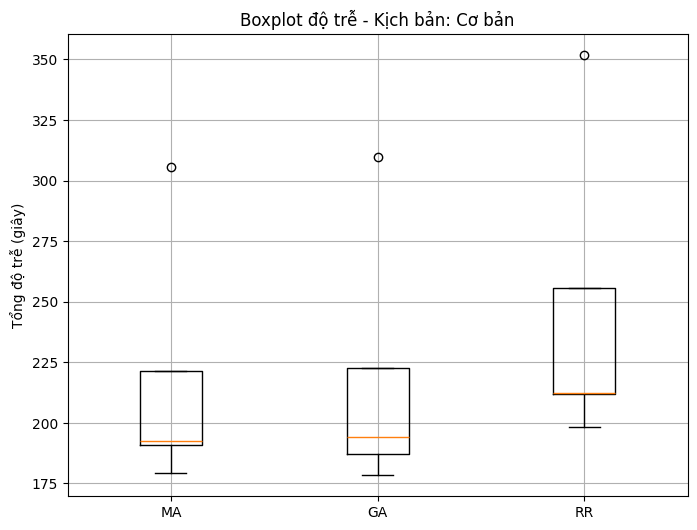


=== Kịch bản: Tăng số tác vụ ===
Đang chạy mô phỏng 1/5 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 2/5 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 3/5 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 4/5 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 5/5 cho kịch bản Tăng số tác vụ

Đánh giá độ tin cậy qua 5 lần chạy:
Memetic Algorithm:
  - Trung bình: 445.19 giây
  - Độ lệch chuẩn: 38.41 giây
  - Khoảng tin cậy 95%: [391.86, 498.51] giây
Genetic Algorithm:
  - Trung bình: 450.46 giây
  - Độ lệch chuẩn: 35.97 giây
  - Khoảng tin cậy 95%: [400.52, 500.40] giây
Round-Robin:
  - Trung bình: 496.19 giây
  - Độ lệch chuẩn: 40.54 giây
  - Khoảng tin cậy 95%: [439.91, 552.48] giây

Kiểm định t-test (MA vs GA): t = -0.20, p-value = 0.8462
Kiểm định t-test (MA vs RR): t = -1.83, p-value = 0.1052


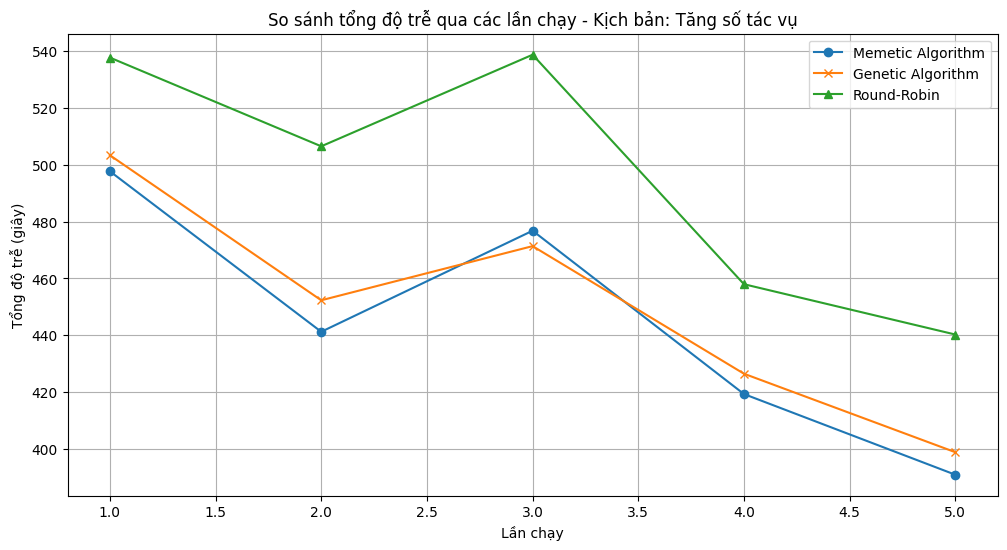

<ipython-input-5-d1df14f66670>:253: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ma_latencies, ga_latencies, rr_latencies], labels=["MA", "GA", "RR"])


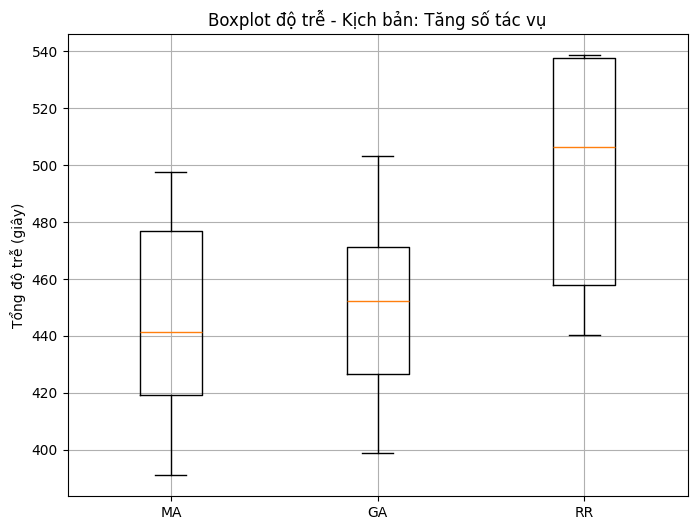


=== Kịch bản: Tăng số nút fog ===
Đang chạy mô phỏng 1/5 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 2/5 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 3/5 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 4/5 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 5/5 cho kịch bản Tăng số nút fog

Đánh giá độ tin cậy qua 5 lần chạy:
Memetic Algorithm:
  - Trung bình: 230.84 giây
  - Độ lệch chuẩn: 20.09 giây
  - Khoảng tin cậy 95%: [202.94, 258.73] giây
Genetic Algorithm:
  - Trung bình: 237.16 giây
  - Độ lệch chuẩn: 19.11 giây
  - Khoảng tin cậy 95%: [210.64, 263.69] giây
Round-Robin:
  - Trung bình: 273.55 giây
  - Độ lệch chuẩn: 22.91 giây
  - Khoảng tin cậy 95%: [241.74, 305.36] giây

Kiểm định t-test (MA vs GA): t = -0.46, p-value = 0.6604
Kiểm định t-test (MA vs RR): t = -2.80, p-value = 0.0231


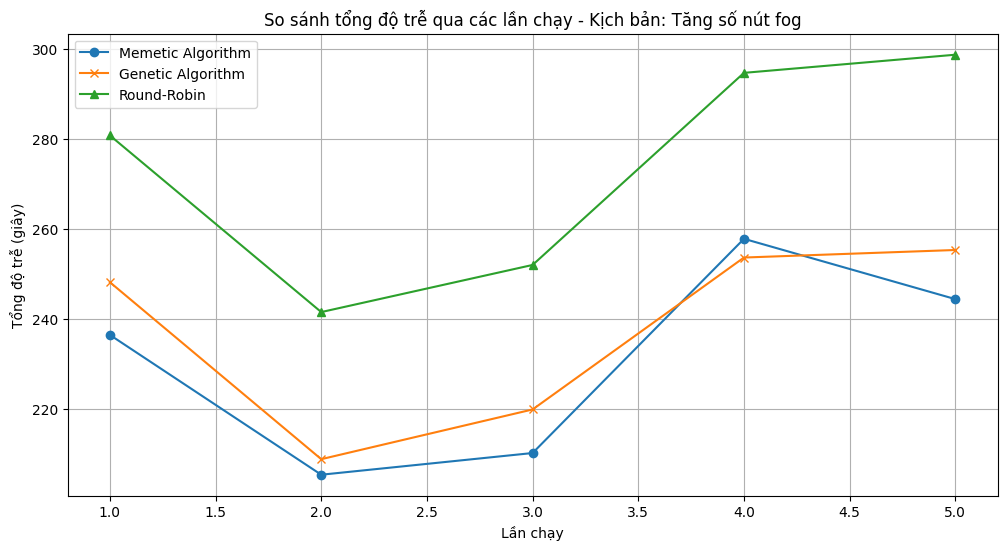

<ipython-input-5-d1df14f66670>:253: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ma_latencies, ga_latencies, rr_latencies], labels=["MA", "GA", "RR"])


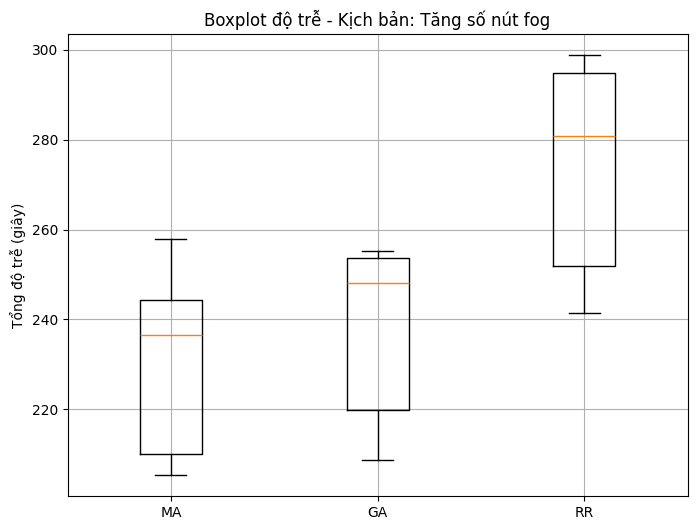


=== Kịch bản: Node quá tải ===
Đang chạy mô phỏng 1/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:
Node 0 quá tải với CPU usage: 0.89
Đang chạy mô phỏng 2/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:
Đang chạy mô phỏng 3/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:
Node 1 quá tải với CPU usage: 0.88
Đang chạy mô phỏng 4/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:
Node 0 quá tải với CPU usage: 1.74
Node 1 quá tải với CPU usage: 1.34
Đang chạy mô phỏng 5/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:

Đánh giá độ tin cậy qua 5 lần chạy:
Memetic Algorithm:
  - Trung bình: 16.66 giây
  - Độ lệch chuẩn: 2.61 giây
  - Khoảng tin cậy 95%: [13.04, 20.27] giây
Genetic Algorithm:
  - Trung bình: 14.66 giây
  - Độ lệch chuẩn: 2.20 giây
  - Khoảng tin cậy 95%: [11.60, 17.71] giây
Round-Robin:
  - Trung bình: 23.51 giây
  - Độ lệch chuẩn: 7.86 giây
  - Khoảng tin cậy 95%: [12.60, 34.43] giây


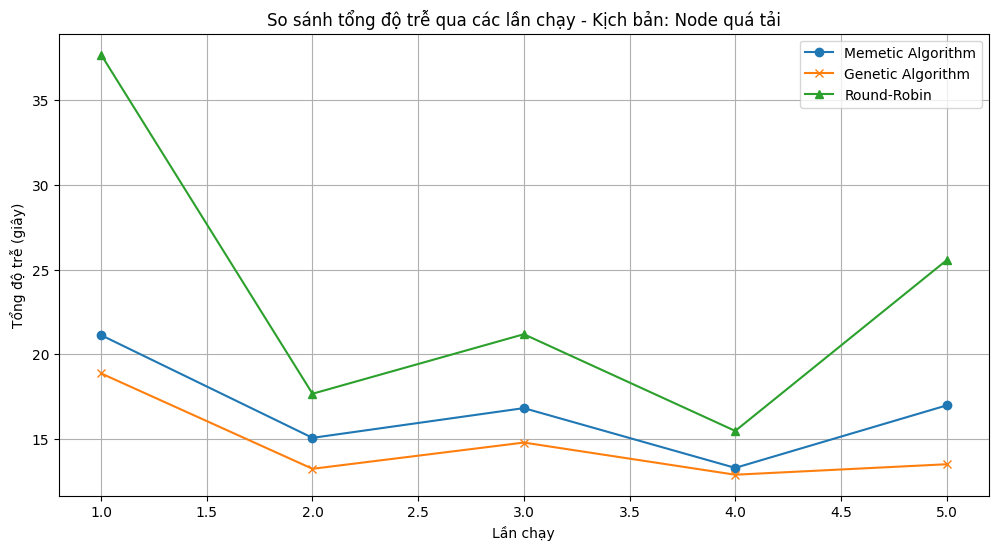

<ipython-input-5-d1df14f66670>:253: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ma_latencies, ga_latencies, rr_latencies], labels=["MA", "GA", "RR"])


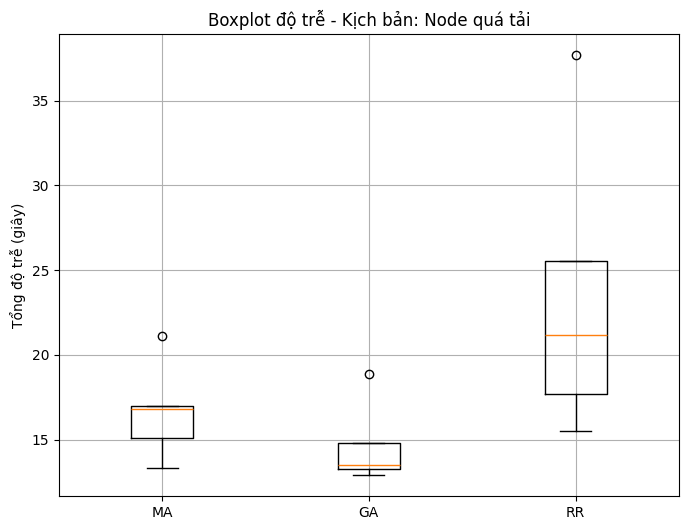

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats

# Tham số mô phỏng (giữ nguyên như code gốc)
POP_SIZE = 100
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MAX_GENERATIONS = 100
CPU_THRESHOLD = 0.8
NUM_RUNS = 5

SCENARIOS = [
    {"name": "Cơ bản", "NUM_FOG_NODES": 10, "NUM_TASKS": 100},
    {"name": "Tăng số tác vụ", "NUM_FOG_NODES": 10, "NUM_TASKS": 200},
    {"name": "Tăng số nút fog", "NUM_FOG_NODES": 15, "NUM_TASKS": 100},
    {"name": "Node quá tải", "NUM_FOG_NODES": 3, "NUM_TASKS": 10}
]

# Các lớp FogNode và Task giữ nguyên như code gốc
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10

# Các hàm cơ bản giữ nguyên
def initialize_system(num_fog_nodes, num_tasks):
    fog_nodes = [FogNode(i, random.uniform(1000, 5000), random.uniform(10, 50))
                 for i in range(num_fog_nodes)]
    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9))
             for i in range(num_tasks)]
    return fog_nodes, tasks

def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

def initialize_population(popsize, num_tasks, num_fog_nodes):
    return [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)]
            for _ in range(popsize)]

def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

def select(population, fitnesses):
    weights = [1 / (f + 1e-6) for f in fitnesses]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    return random.choices(population, weights=weights, k=1)[0]

def genetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitnesses = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            new_population.extend([child1, child2])
        population = new_population
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

def local_search(individual, fog_nodes, tasks):
    best_individual = individual[:]
    best_fitness = fitness_function(best_individual, fog_nodes, tasks)
    for _ in range(3):
        neighbor = best_individual[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        neighbor_fitness = fitness_function(neighbor, fog_nodes, tasks)
        if neighbor_fitness < best_fitness:
            best_individual = neighbor[:]
            best_fitness = neighbor_fitness
    return best_individual

def reassign_tasks(individual, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
        node.current_tasks = [tasks[i] for i, node_id in enumerate(individual) if node_id == node.id]
        node.current_cpu_load = sum(task.computation_size for task in node.current_tasks)
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        if cpu_usage > CPU_THRESHOLD and node.current_tasks:
            underloaded_nodes = [n for n in fog_nodes if (n.current_cpu_load / n.cpu_capacity) < 0.5]
            if underloaded_nodes:
                task_to_move = node.current_tasks[-1]
                task_idx = tasks.index(task_to_move)
                target_node = min(underloaded_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
                individual[task_idx] = target_node.id
    return individual

def memetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitness_values = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            child1 = local_search(child1, fog_nodes, tasks)
            child2 = local_search(child2, fog_nodes, tasks)
            new_population.extend([child1, child2])
        population = [reassign_tasks(ind, fog_nodes, tasks) for ind in new_population]
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

def round_robin_assignment(num_tasks, num_fog_nodes):
    return [i % num_fog_nodes for i in range(num_tasks)]

def check_overload(fog_nodes):
    overloaded = False
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        if cpu_usage > CPU_THRESHOLD:
            print(f"Node {node.id} quá tải với CPU usage: {cpu_usage:.2f}")
            overloaded = True
    return overloaded

# Hàm mới để tính khoảng tin cậy 95%
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean - h, mean + h

# Chạy mô phỏng với đánh giá độ tin cậy
def run_simulation_with_evaluation():
    for scenario in SCENARIOS:
        print(f"\n=== Kịch bản: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]

        ma_latencies = []
        ga_latencies = []
        rr_latencies = []

        for run in range(NUM_RUNS):
            print(f"Đang chạy mô phỏng {run + 1}/{NUM_RUNS} cho kịch bản {scenario['name']}")
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks)

            # Memetic Algorithm
            ma_fitness = memetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ma_latencies.append(ma_fitness)

            # Genetic Algorithm
            ga_fitness = genetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ga_latencies.append(ga_fitness)

            # Round-Robin
            rr_solution = round_robin_assignment(num_tasks, num_fog_nodes)
            rr_fitness = fitness_function(rr_solution, fog_nodes, tasks)
            rr_latencies.append(rr_fitness)

            # Kiểm tra node quá tải trong kịch bản thứ tư
            if scenario["name"] == "Node quá tải":
                print("Kiểm tra node quá tải sau Round-Robin:")
                check_overload(fog_nodes)

        # Tính toán các chỉ số đánh giá
        ma_mean, ma_std = np.mean(ma_latencies), np.std(ma_latencies)
        ga_mean, ga_std = np.mean(ga_latencies), np.std(ga_latencies)
        rr_mean, rr_std = np.mean(rr_latencies), np.std(rr_latencies)

        ma_ci = confidence_interval(ma_latencies)
        ga_ci = confidence_interval(ga_latencies)
        rr_ci = confidence_interval(rr_latencies)

        # In kết quả đánh giá
        print(f"\nĐánh giá độ tin cậy qua {NUM_RUNS} lần chạy:")
        print(f"Memetic Algorithm:")
        print(f"  - Trung bình: {ma_mean:.2f} giây")
        print(f"  - Độ lệch chuẩn: {ma_std:.2f} giây")
        print(f"  - Khoảng tin cậy 95%: [{ma_ci[0]:.2f}, {ma_ci[1]:.2f}] giây")
        print(f"Genetic Algorithm:")
        print(f"  - Trung bình: {ga_mean:.2f} giây")
        print(f"  - Độ lệch chuẩn: {ga_std:.2f} giây")
        print(f"  - Khoảng tin cậy 95%: [{ga_ci[0]:.2f}, {ga_ci[1]:.2f}] giây")
        print(f"Round-Robin:")
        print(f"  - Trung bình: {rr_mean:.2f} giây")
        print(f"  - Độ lệch chuẩn: {rr_std:.2f} giây")
        print(f"  - Khoảng tin cậy 95%: [{rr_ci[0]:.2f}, {rr_ci[1]:.2f}] giây")

        # So sánh thống kê (t-test giữa MA và GA, MA và RR)
        t_stat_ma_ga, p_val_ma_ga = stats.ttest_ind(ma_latencies, ga_latencies)
        t_stat_ma_rr, p_val_ma_rr = stats.ttest_ind(ma_latencies, rr_latencies)
        print(f"\nKiểm định t-test (MA vs GA): t = {t_stat_ma_ga:.2f}, p-value = {p_val_ma_ga:.4f}")
        print(f"Kiểm định t-test (MA vs RR): t = {t_stat_ma_rr:.2f}, p-value = {p_val_ma_rr:.4f}")

        # Vẽ biểu đồ so sánh
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, NUM_RUNS + 1), ma_latencies, label="Memetic Algorithm", marker='o')
        plt.plot(range(1, NUM_RUNS + 1), ga_latencies, label="Genetic Algorithm", marker='x')
        plt.plot(range(1, NUM_RUNS + 1), rr_latencies, label="Round-Robin", marker='^')
        plt.xlabel("Lần chạy")
        plt.ylabel("Tổng độ trễ (giây)")
        plt.title(f"So sánh tổng độ trễ qua các lần chạy - Kịch bản: {scenario['name']}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Vẽ boxplot để trực quan hóa độ ổn định
        plt.figure(figsize=(8, 6))
        plt.boxplot([ma_latencies, ga_latencies, rr_latencies], labels=["MA", "GA", "RR"])
        plt.ylabel("Tổng độ trễ (giây)")
        plt.title(f"Boxplot độ trễ - Kịch bản: {scenario['name']}")
        plt.grid(True)
        plt.show()

# Chạy chương trình
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation_with_evaluation()

makespan

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Tham số mô phỏng
POP_SIZE = 50
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MAX_GENERATIONS = 100
NUM_RUNS = 10

# Kịch bản mô phỏng
SCENARIOS = [
    {"name": "Cơ bản", "NUM_FOG_NODES": 10, "NUM_TASKS": 200},
    {"name": "Tăng số tác vụ", "NUM_FOG_NODES": 10, "NUM_TASKS": 400},
    {"name": "Tăng số nút fog", "NUM_FOG_NODES": 20, "NUM_TASKS": 200},
]

# Lớp FogNode
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

# Lớp Task
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10

# Khởi tạo hệ thống
def initialize_system(num_fog_nodes, num_tasks):
    fog_nodes = [FogNode(i, random.uniform(1000, 5000), random.uniform(10, 50)) for i in range(num_fog_nodes)]
    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9)) for i in range(num_tasks)]
    return fog_nodes, tasks

# Tính thời gian hoàn thành
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# Hàm đánh giá
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

# Khởi tạo quần thể
def initialize_population(popsize, num_tasks, num_fog_nodes):
    return [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]

# Lai ghép
def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# Đột biến
def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

# Chọn lọc
def select(population, fitnesses):
    weights = [1 / (f + 1e-6) for f in fitnesses]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    return random.choices(population, weights=weights, k=1)[0]

# Thuật toán di truyền (GA)
def genetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitnesses = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            new_population.extend([child1, child2])
        population = new_population
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Tìm kiếm cục bộ
def local_search(individual, fog_nodes, tasks):
    best_individual = individual[:]
    best_fitness = fitness_function(best_individual, fog_nodes, tasks)
    for _ in range(3):
        neighbor = best_individual[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        neighbor_fitness = fitness_function(neighbor, fog_nodes, tasks)
        if neighbor_fitness < best_fitness:
            best_individual = neighbor[:]
            best_fitness = neighbor_fitness
    return best_individual

# Thuật toán Memetic (MA)
def memetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitness_values = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            child1 = local_search(child1, fog_nodes, tasks)
            child2 = local_search(child2, fog_nodes, tasks)
            new_population.extend([child1, child2])
        population = new_population
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Phân bổ Round-Robin (RR)
def round_robin_assignment(num_tasks, num_fog_nodes):
    return [i % num_fog_nodes for i in range(num_tasks)]

# Chạy mô phỏng
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Kịch bản: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]

        ma_latencies = []
        ga_latencies = []
        rr_latencies = []

        for run in range(NUM_RUNS):
            print(f"Đang chạy mô phỏng {run + 1}/{NUM_RUNS} cho kịch bản {scenario['name']}")
            fog_nodes, tasks = initialize_

GA-m, MA0 RR


=== Kịch bản: Cơ bản ===
Đang chạy mô phỏng 1/5 cho kịch bản Cơ bản
Đang chạy mô phỏng 2/5 cho kịch bản Cơ bản
Đang chạy mô phỏng 3/5 cho kịch bản Cơ bản
Đang chạy mô phỏng 4/5 cho kịch bản Cơ bản
Đang chạy mô phỏng 5/5 cho kịch bản Cơ bản

Kết quả (BEST, AVG, STD) sau 5 lần chạy cho kịch bản: Cơ bản
Memetic Algorithm:  BEST = 171.11,  AVG = 236.51,  STD = 52.45
GA-M:               BEST = 150.22,  AVG = 186.58,  STD = 28.81
Round-Robin:        BEST = 169.35,  AVG = 263.02,  STD = 52.97


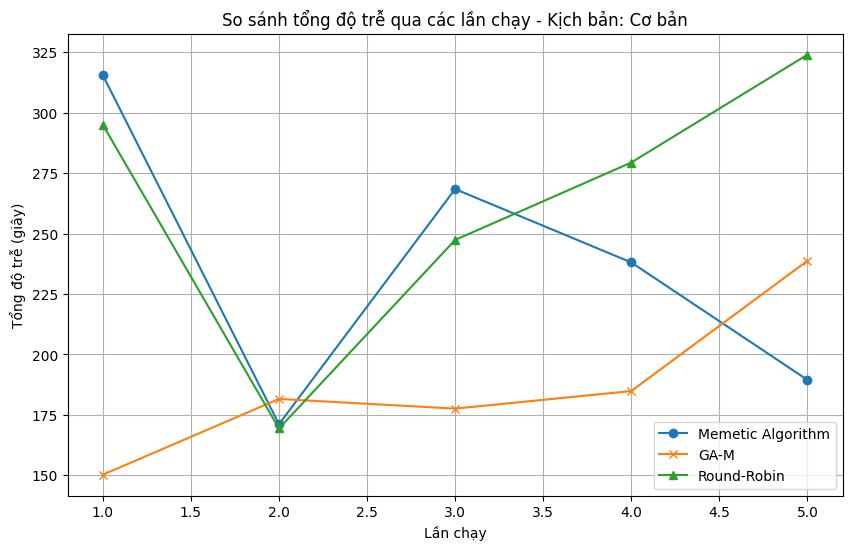


=== Kịch bản: Tăng số tác vụ ===
Đang chạy mô phỏng 1/5 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 2/5 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 3/5 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 4/5 cho kịch bản Tăng số tác vụ
Đang chạy mô phỏng 5/5 cho kịch bản Tăng số tác vụ

Kết quả (BEST, AVG, STD) sau 5 lần chạy cho kịch bản: Tăng số tác vụ
Memetic Algorithm:  BEST = 438.21,  AVG = 483.01,  STD = 32.84
GA-M:               BEST = 338.97,  AVG = 395.99,  STD = 40.97
Round-Robin:        BEST = 505.98,  AVG = 519.71,  STD = 22.14


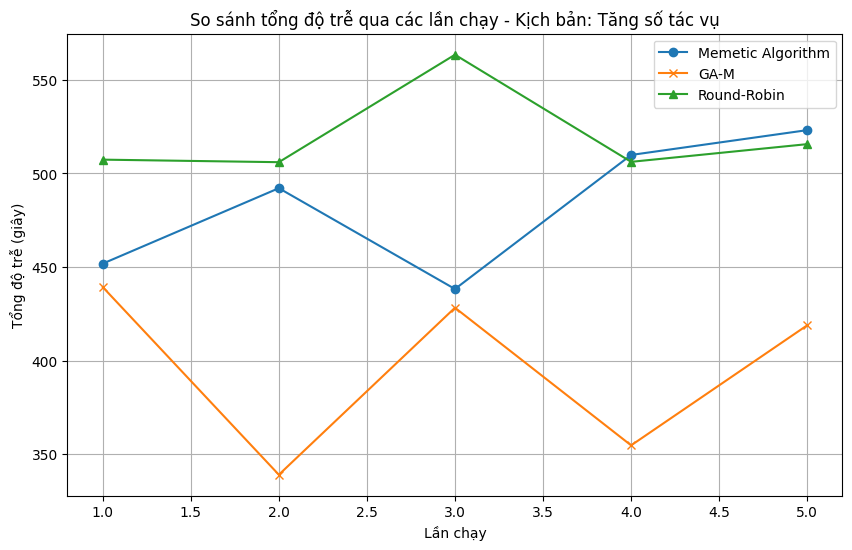


=== Kịch bản: Tăng số nút fog ===
Đang chạy mô phỏng 1/5 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 2/5 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 3/5 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 4/5 cho kịch bản Tăng số nút fog
Đang chạy mô phỏng 5/5 cho kịch bản Tăng số nút fog

Kết quả (BEST, AVG, STD) sau 5 lần chạy cho kịch bản: Tăng số nút fog
Memetic Algorithm:  BEST = 189.82,  AVG = 219.81,  STD = 17.24
GA-M:               BEST = 179.32,  AVG = 198.54,  STD = 10.31
Round-Robin:        BEST = 200.97,  AVG = 234.53,  STD = 27.91


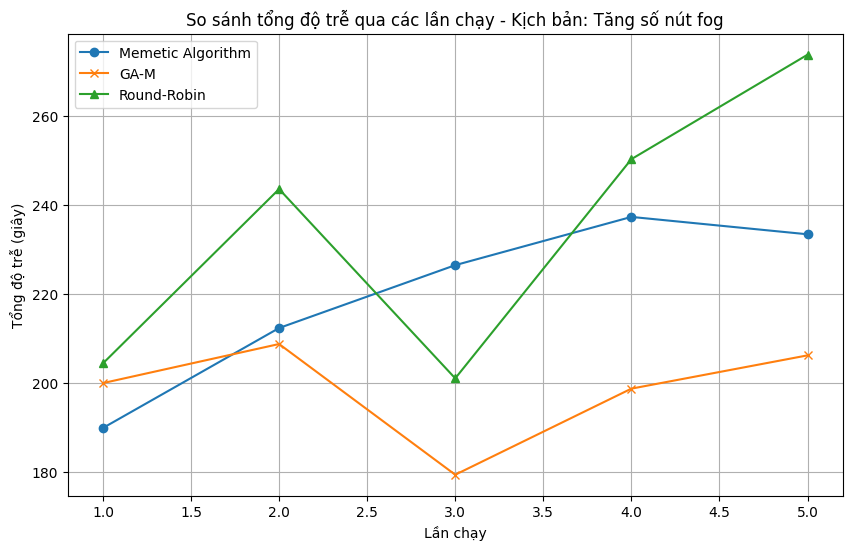


=== Kịch bản: Node quá tải ===
Đang chạy mô phỏng 1/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:
Node 1 quá tải với CPU usage: 1.37
Node 4 quá tải với CPU usage: 0.92
Đang chạy mô phỏng 2/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:
Node 2 quá tải với CPU usage: 1.20
Node 3 quá tải với CPU usage: 1.56
Đang chạy mô phỏng 3/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:
Node 4 quá tải với CPU usage: 0.83
Đang chạy mô phỏng 4/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:
Đang chạy mô phỏng 5/5 cho kịch bản Node quá tải
Kiểm tra node quá tải sau Round-Robin:
Node 2 quá tải với CPU usage: 1.02
Node 3 quá tải với CPU usage: 0.84

Kết quả (BEST, AVG, STD) sau 5 lần chạy cho kịch bản: Node quá tải
Memetic Algorithm:  BEST = 14.39,  AVG = 17.20,  STD = 1.70
GA-M:               BEST = 13.36,  AVG = 15.64,  STD = 1.66
Round-Robin:        BEST = 15.86,  AVG = 23.77,  STD = 7.32


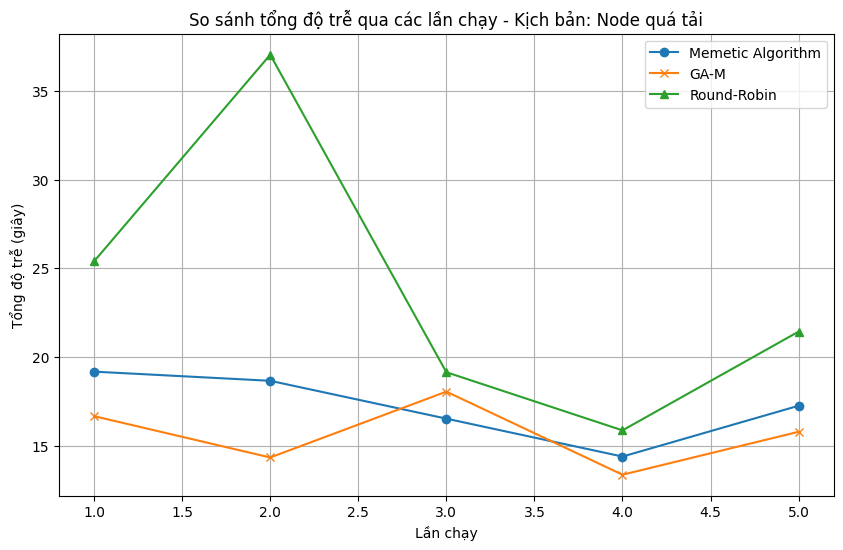

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Tham số mô phỏng
POP_SIZE = 50         # Kích thước quần thể
CROSSOVER_RATE = 0.8  # Tỷ lệ lai ghép
MUTATION_RATE = 0.2   # Tỷ lệ đột biến
MAX_GENERATIONS = 100 # Số thế hệ tối đa
CPU_THRESHOLD = 0.8   # Ngưỡng quá tải CPU
NUM_RUNS = 5          # Số lần chạy độc lập

# Định nghĩa các kịch bản mô phỏng
SCENARIOS = [
    {"name": "Cơ bản", "NUM_FOG_NODES": 5, "NUM_TASKS": 100},
    {"name": "Tăng số tác vụ", "NUM_FOG_NODES": 20, "NUM_TASKS": 200},
    {"name": "Tăng số nút fog", "NUM_FOG_NODES": 30, "NUM_TASKS": 100},
    {"name": "Node quá tải", "NUM_FOG_NODES": 5, "NUM_TASKS": 10}
]

# Lớp đại diện cho node fog
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

# Lớp đại diện cho tác vụ
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10

# Khởi tạo hệ thống
def initialize_system(num_fog_nodes, num_tasks):
    fog_nodes = [FogNode(i, random.uniform(1000, 5000), random.uniform(10, 50))
                 for i in range(num_fog_nodes)]
    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9))
             for i in range(num_tasks)]
    return fog_nodes, tasks

# Tính độ trễ hoàn thành
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# Hàm đánh giá
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

# Khởi tạo quần thể
def initialize_population(popsize, num_tasks, num_fog_nodes):
    return [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)]
            for _ in range(popsize)]

# Lai ghép
def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# Đột biến
def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

# Chọn cá thể
def select(population, fitnesses):
    weights = [1 / (f + 1e-6) for f in fitnesses]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    return random.choices(population, weights=weights, k=1)[0]

# Thuật toán GA-M
def ga_m_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    """
    Thuật toán GA-M cải tiến dựa trên các đặc điểm từ GARunner (Myszkowski P. B.).
    - Sử dụng lai ghép hai điểm (two-point crossover).
    - Tích hợp tìm kiếm cục bộ đơn giản (local search).
    - Ưu tiên các giải pháp tránh quá tải CPU.
    """
    population = initialize_population(popsize, num_tasks, num_fog_nodes)

    for gen in range(generations):
        fitnesses = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []

        # Elitism: Giữ lại cá thể tốt nhất
        best_idx = fitnesses.index(min(fitnesses))
        new_population.append(population[best_idx][:])

        # Tạo các cá thể mới
        while len(new_population) < popsize:
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)

            # Lai ghép hai điểm
            if random.random() < pcrossover and len(parent1) > 2:
                point1 = random.randint(1, len(parent1) - 2)
                point2 = random.randint(point1 + 1, len(parent1) - 1)
                child = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
            else:
                child = parent1[:]

            # Đột biến
            child = mutate(child, num_fog_nodes, pmutation)

            # Tìm kiếm cục bộ
            child = local_search(child, fog_nodes, tasks)

            # Tái phân bổ tác vụ
            child = reassign_tasks(child, fog_nodes, tasks)

            new_population.append(child)

        population = new_population[:popsize]

    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Tìm kiếm cục bộ
def local_search(individual, fog_nodes, tasks):
    best_individual = individual[:]
    best_fitness = fitness_function(best_individual, fog_nodes, tasks)
    for _ in range(3):
        neighbor = best_individual[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        neighbor_fitness = fitness_function(neighbor, fog_nodes, tasks)
        if neighbor_fitness < best_fitness:
            best_individual = neighbor[:]
            best_fitness = neighbor_fitness
    return best_individual

# Tái phân bổ tác vụ
def reassign_tasks(individual, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
        node.current_tasks = [tasks[i] for i, node_id in enumerate(individual) if node_id == node.id]
        node.current_cpu_load = sum(task.computation_size for task in node.current_tasks)
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        if cpu_usage > CPU_THRESHOLD and node.current_tasks:
            underloaded_nodes = [n for n in fog_nodes if (n.current_cpu_load / n.cpu_capacity) < 0.5]
            if underloaded_nodes:
                task_to_move = node.current_tasks[-1]
                task_idx = tasks.index(task_to_move)
                target_node = min(underloaded_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
                individual[task_idx] = target_node.id
    return individual

# Thuật toán Memetic
def memetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)
    for _ in range(generations):
        fitness_values = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            child1 = local_search(child1, fog_nodes, tasks)
            child2 = local_search(child2, fog_nodes, tasks)
            new_population.extend([child1, child2])
        population = [reassign_tasks(ind, fog_nodes, tasks) for ind in new_population]
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# Phân bổ Round-Robin
def round_robin_assignment(num_tasks, num_fog_nodes):
    return [i % num_fog_nodes for i in range(num_tasks)]

# Kiểm tra node quá tải
def check_overload(fog_nodes):
    overloaded = False
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        if cpu_usage > CPU_THRESHOLD:
            print(f"Node {node.id} quá tải với CPU usage: {cpu_usage:.2f}")
            overloaded = True
    return overloaded

# Chạy mô phỏng
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Kịch bản: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]

        ma_latencies = []
        ga_m_latencies = []
        rr_latencies = []

        for run in range(NUM_RUNS):
            print(f"Đang chạy mô phỏng {run + 1}/{NUM_RUNS} cho kịch bản {scenario['name']}")
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks)

            # Memetic Algorithm
            ma_fitness = memetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ma_latencies.append(ma_fitness)

            # GA-M
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks)
            ga_m_fitness = ga_m_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            ga_m_latencies.append(ga_m_fitness)

            # Round-Robin
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks)
            rr_solution = round_robin_assignment(num_tasks, num_fog_nodes)
            rr_fitness = fitness_function(rr_solution, fog_nodes, tasks)
            rr_latencies.append(rr_fitness)

            if scenario["name"] == "Node quá tải":
                print("Kiểm tra node quá tải sau Round-Robin:")
                check_overload(fog_nodes)

        # Tính toán BEST, AVG, STD
        ma_best, ma_avg, ma_std = min(ma_latencies), np.mean(ma_latencies), np.std(ma_latencies)
        ga_m_best, ga_m_avg, ga_m_std = min(ga_m_latencies), np.mean(ga_m_latencies), np.std(ga_m_latencies)
        rr_best, rr_avg, rr_std = min(rr_latencies), np.mean(rr_latencies), np.std(rr_latencies)

        # In kết quả
        print(f"\nKết quả (BEST, AVG, STD) sau {NUM_RUNS} lần chạy cho kịch bản: {scenario['name']}")
        print(f"Memetic Algorithm:  BEST = {ma_best:.2f},  AVG = {ma_avg:.2f},  STD = {ma_std:.2f}")
        print(f"GA-M:               BEST = {ga_m_best:.2f},  AVG = {ga_m_avg:.2f},  STD = {ga_m_std:.2f}")
        print(f"Round-Robin:        BEST = {rr_best:.2f},  AVG = {rr_avg:.2f},  STD = {rr_std:.2f}")

        # Vẽ biểu đồ
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, NUM_RUNS + 1), ma_latencies, label="Memetic Algorithm", marker='o')
        plt.plot(range(1, NUM_RUNS + 1), ga_m_latencies, label="GA-M", marker='x')
        plt.plot(range(1, NUM_RUNS + 1), rr_latencies, label="Round-Robin", marker='^')
        plt.xlabel("Lần chạy")
        plt.ylabel("Tổng độ trễ (giây)")
        plt.title(f"So sánh tổng độ trễ qua các lần chạy - Kịch bản: {scenario['name']}")
        plt.legend()
        plt.grid(True)
        plt.show()

# Chạy chương trình
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()